In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path
import yaml
import re

import pyarrow as pa
import pyarrow.parquet as pq

import gbd_mapping as gm
from vivarium import Artifact

# from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
# from get_draws.api import get_draws

import vivarium_helpers as vh
# import vivarium_helpers.id_helper as idh
from vivarium_helpers.vph_output.operations import VPHOperator

!date
!whoami
!pwd

Fri Feb  6 16:39:42 PST 2026
ndbs
/Users/ndbs/repos/vivarium_research_alzheimers/verification_and_validation


# Show versions of Vivarium libraries

In [4]:
!pip list | grep vivarium

vivarium                  3.6.6
vivarium_build_utils      2.2.2
vivarium_dependencies     1.0.5
vivarium_helpers          0.5.0.dev251111   /Users/ndbs/repos/vivarium_helpers


In [5]:
!pip freeze | grep vivarium

vivarium==3.6.6
vivarium_build_utils==2.2.2
vivarium_dependencies==1.0.5
-e git+https://github.com/ihmeuw/vivarium_helpers.git@14726994615ddaac5513f19155799d6debf4ecb7#egg=vivarium_helpers


# V&V list

# Find data

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model12.1/model_spec/2026_02_04_10_16_58

In [6]:
# Project directory on the cluster
project_dir = '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/'

if os.sys.platform == 'darwin':
    # Notebook is running on Nathaniel's MacBook
    local_project_dir = "/Users/ndbs/project_data/vivarium_csu_alzheimers/"
else:
    # Assume we're running on the cluster
    local_project_dir = project_dir

In [7]:
# Project directory
%cd $local_project_dir

/Users/ndbs/project_data/vivarium_csu_alzheimers


In [8]:
# Results directory containing model 7.6 results for all locations
model_run_subdir = 'results/model12.1/model_spec/2026_02_04_10_16_58/'
!ls -halt $model_run_subdir/results

total 0
drwx------  11 ndbs  staff   352B Feb  5 09:57 ..
drwx------   3 ndbs  staff    96B Feb  5 09:57 counts_newly_eligible_for_bbbm_testing
drwx------   3 ndbs  staff    96B Feb  5 09:56 person_time_treatment
drwx------   3 ndbs  staff    96B Feb  5 09:56 ylds
drwx------   3 ndbs  staff    96B Feb  5 09:56 transition_count_treatment
drwx------   3 ndbs  staff    96B Feb  5 09:55 counts_baseline_tests_among_eligible
drwx------   3 ndbs  staff    96B Feb  5 09:55 deaths
drwx------   3 ndbs  staff    96B Feb  5 09:55 transition_count_alzheimers_disease_and_other_dementias
drwx------   3 ndbs  staff    96B Feb  5 09:54 person_time_ever_eligible_for_bbbm_testing
drwx------   3 ndbs  staff    96B Feb  5 09:53 counts_new_simulants
drwx------   3 ndbs  staff    96B Feb  5 09:53 person_time_alzheimers_disease_and_other_dementias
drwx------   3 ndbs  staff    96B Feb  5 09:52 treatment_duration
drwx------   3 ndbs  staff    96B Feb  5 09:51 counts_bbbm_tests
drwx------   3 ndbs  staff    96B

In [9]:
!ls $model_run_subdir

__pycache__               keyspace.yaml             requirements.txt
branches.yaml             logs                      results
finished_sim_metadata.csv model_specification.yaml  settings.py


In [10]:
!ls artifacts/model8.3

brazil.hdf                     spain.hdf
china.hdf                      sweden.hdf
germany.hdf                    taiwan_(province_of_china).hdf
israel.hdf                     united_kingdom.hdf
japan.hdf                      united_states_of_america.hdf


In [12]:
locations = [
    'United States of America',
    'Brazil',
    'China',
    # 'Germany',
    # 'Israel',
    # 'Japan',
    # 'Spain',
    # 'Sweden',
    # 'Taiwan (Province of China)',
    # 'United Kingdom',
]

# Define some shorter names to use for plotting
location_to_short_name = ({loc: loc for loc in locations}| {
    'Taiwan (Province of China)': 'Taiwan',
    'United Kingdom': 'UK',
    'United States of America': 'USA',
})

# Select a subset of locations to draw plots for
# locations_to_plot = locations[:2]

# project_dir = '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/'

artifact_model_number = '10.0' # Artifacts are stored here
run_subdirectories = [
    model_run_subdir,
]
# Where results are stored locally
run_dirs = [local_project_dir + run_subdir for run_subdir in run_subdirectories]
results_dirs = [run_dir + 'results/' for run_dir in run_dirs]

# # Option 1: One results directory per location
# location_to_results_dir = {
#     loc: path for loc, path in zip(locations, results_dirs)}

# Option 2: All locations in one results directory
location_to_results_dir = {'all': results_dirs[0]}

location_to_artifact_subdir = {loc: loc.lower().replace(' ', '_') for loc in locations}
artifact_subpaths = [f'artifacts/model{artifact_model_number}/' + subdir + '.hdf' for subdir in location_to_artifact_subdir.values()]
# Map locations to where artifacts are stored locally (for reading artifact data)
location_to_local_artifact_path = {
    loc: local_project_dir + subpath for loc, subpath in zip(locations, artifact_subpaths)}
# Map locations to where artifacts are stored on the cluster (for adding locations to sim results)
location_to_artifact_path = {loc: project_dir + subpath for loc, subpath in zip(locations, artifact_subpaths)}
# artifact_path_to_location = {path: loc for loc, path in location_to_artifact_path.items()}
# artifact_path_to_location = {project_dir + subpath: loc for subpath, loc in zip(artifact_subpaths, locations)}
location_to_artifact_path

{'United States of America': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf',
 'Brazil': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/brazil.hdf',
 'China': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'}

In [13]:
results_dirs

['/Users/ndbs/project_data/vivarium_csu_alzheimers/results/model12.1/model_spec/2026_02_04_10_16_58/results/']

In [14]:
d = results_dirs[0]
!ls $d

counts_baseline_tests_among_eligible
counts_bbbm_tests
counts_new_simulants
counts_newly_eligible_for_bbbm_testing
deaths
person_time_alzheimers_disease_and_other_dementias
person_time_eligible_for_bbbm_testing
person_time_ever_eligible_for_bbbm_testing
person_time_treatment
transition_count_alzheimers_disease_and_other_dementias
transition_count_treatment
treatment_duration
ylds
ylls


# Get list of draws and draw columns from `keyspace.yaml`, and reduce to a subset of draws to save memory and time

In [98]:
with open(run_dirs[0] + 'keyspace.yaml', 'r') as keyspace_file:
    keyspace = yaml.safe_load(keyspace_file)
draws = keyspace['input_draw']
print(draws)

[172, 235, 204, 219, 245, 69, 1, 211, 35, 187, 6, 249, 7, 236, 183, 103, 41, 123, 63, 199, 248, 122, 161, 50, 24]


In [100]:
# I ended up never actually using this -- I just used all the draws
draws = sorted(draws[:]) # reduce to a subset of draws to save memory, and sort
draw_cols = [f'draw_{i}' for i in draws]
print(draw_cols)

['draw_1', 'draw_6', 'draw_7', 'draw_24', 'draw_35', 'draw_41', 'draw_50', 'draw_63', 'draw_69', 'draw_103', 'draw_122', 'draw_123', 'draw_161', 'draw_172', 'draw_183', 'draw_187', 'draw_199', 'draw_204', 'draw_211', 'draw_219', 'draw_235', 'draw_236', 'draw_245', 'draw_248', 'draw_249']


# Define some ordered Categorical dtypes, and convert years to ints

In [17]:
# Order locations lexicographically
all_locations = [
    'United States of America',
    'Brazil',
    'China',
    'Germany',
    'Israel',
    'Japan',
    'Spain',
    'Sweden',
    'Taiwan (Province of China)',
    'United Kingdom',
]
location_dtype = pd.CategoricalDtype(sorted(all_locations), ordered=True)

# Order years chronologically (for some reason years are strings in the output)
# years = [str(year) for year in range(2025, 2101)]
# year_dtype = pd.CategoricalDtype(years, ordered=True)
# int16 ranges from -32768 to 32767 (I think), which is sufficient to
# represent all years 2025-2100. uint8 only goes from 0 to 255, which is
# too small.
year_dtype = 'int16'

# Order age groups chronologically
age_groups = [f'{age}_to_{age + 4}' for age in range(25, 95, 5)] + ['95_plus']
age_group_dtype = pd.CategoricalDtype(age_groups, ordered=True)

# Order scenarios by complexity
scenarios = ['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment']
scenario_dtype = pd.CategoricalDtype(scenarios, ordered=True)

colname_to_dtype = {
    'location': location_dtype,
    'event_year': year_dtype,
    'age_group': age_group_dtype,
    'scenario': scenario_dtype,
}

# Load one artifact and define age bins

In [19]:
usa_artifact_path = location_to_local_artifact_path['United States of America']
usa_art = Artifact(usa_artifact_path)
print(usa_art.load('metadata.locations'))
print(usa_art)

['United States of America']
Artifact containing the following keys:
metadata
	keyspace
	locations
population
	location
	structure
	age_bins
	demographic_dimensions
	theoretical_minimum_risk_life_expectancy
	scaling_factor
cause
	all_causes
		cause_specific_mortality_rate
	alzheimers
		prevalence
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		mci_to_dementia_transition_rate
		susceptible_to_bbbm_transition_count
		population_incidence_rate
		excess_mortality_rate
		mci_disability_weight
	alzheimers_disease_and_other_dementias
		disability_weight
		restrictions
		cause_specific_mortality_rate
	alzheimers_consistent
		population_incidence_any
		prevalence_any
		population_incidence_dementia
		excess_mortality_rate
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		ode_errors
		susceptible_to_bbbm_transition_count
		dementia_conditional_prevalence
covariate
	live_births_by_sex
		estimate
testing_rates
	csf
	pet
treatment
	relative_risk



In [20]:
# age_bins is an empty DataFrame with a MultiIndex storing age group data
age_bins = usa_art.load('population.age_bins')
age_dictionary = (
    age_bins
    .reset_index()
    .assign(age_group=lambda df: df['age_group_name'].str.replace(' ', '_'))
    # Filter to ages that actually appear in our sim
    .query("age_start >= 25")
)
age_dictionary

,age_group_id,age_group_name,age_start,age_end,age_group
4,10,25 to 29,25.0,30.0,25_to_29
5,11,30 to 34,30.0,35.0,30_to_34
6,12,35 to 39,35.0,40.0,35_to_39
7,13,40 to 44,40.0,45.0,40_to_44
8,14,45 to 49,45.0,50.0,45_to_49
9,15,50 to 54,50.0,55.0,50_to_54
10,16,55 to 59,55.0,60.0,55_to_59
11,17,60 to 64,60.0,65.0,60_to_64
12,18,65 to 69,65.0,70.0,65_to_69
13,19,70 to 74,70.0,75.0,70_to_74


In [21]:
age_bins.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19 entries, (6, '5 to 9', 5.0, 10.0) to (235, '95 plus', 95.0, 125.0)
Empty DataFrame


# Define functions to load and merge Artifact data from all locations, and to summarize Artifact data for plotting

In [24]:
def load_artifact_data(
    key,
    filter_terms=None,
    location_to_artifact_path=location_to_local_artifact_path,
):
    dfs = {} # dict to map locations to artifact data
    for location, path in location_to_artifact_path.items():
        art = Artifact(path, filter_terms)
        # Check to make sure location matches artifact
        art_locations = art.load('metadata.locations')
        assert len(art_locations) == 1 and art_locations[0] == location, \
            f'Unexpected locations in artifact: {location=}, {art_locations=}'
        df = art.load(key)
        dfs[location] = df
    data = pd.concat(dfs, names=['location', *df.index.names])
    return data

def lower(x):
    return x.quantile(0.025)

def upper(x):
    return x.quantile(0.975)

def summarize_artifact_data(df):
    summary = df.agg(['mean', lower, upper], axis='columns')
    return summary

# Load CSF and PET testing rates

In [25]:
# NOTE: Dropping level 1 of index because it is meaningless, containing
# all 0s: 
# https://github.com/ihmeuw/vivarium_csu_alzheimers/blob/7674a25da52e8b9ee23c0184a2e65c6f53aac335/src/vivarium_csu_alzheimers/data/loader.py#L487-L489
csf_rates = load_artifact_data('testing_rates.csf').droplevel(1)
pet_rates = load_artifact_data('testing_rates.pet').droplevel(1)
existing_test_rates = (
    pd.concat(
        {'csf': csf_rates, 'pet': pet_rates}, names=['test_type', 'location'])
    .rename_axis(columns='input_draw')
)
existing_test_rates

input_draw                            draw_0    draw_1    draw_2    draw_3  \
test_type location                                                           
csf       United States of America  0.086170  0.140511  0.102449  0.092320   
          Brazil                    0.105865  0.173411  0.126100  0.113509   
          China                     0.035023  0.057369  0.041717  0.037552   
pet       United States of America  0.172089  0.196148  0.165458  0.088834   
          Brazil                    0.170942  0.194840  0.164355  0.088241   
          China                     0.069983  0.079767  0.067286  0.036126   

input_draw                            draw_4    draw_5    draw_6    draw_7  \
test_type location                                                           
csf       United States of America  0.126445  0.062653  0.118921  0.087192   
          Brazil                    0.155928  0.076634  0.146575  0.107136   
          China                     0.051585  0.025353  0.048491  0.035443   
pet       United States of America  0.164784  0.180419  0.178008  0.223862   
          Brazil                    0.163686  0.179216  0.176821  0.222370   
          China                     0.067012  0.073370  0.072390  0.091037   

input_draw                            draw_8    draw_9  ...  draw_490  \
test_type location                                      ...             
csf       United States of America  0.096971  0.095522  ...  0.131668   
          Brazil                    0.119291  0.117490  ...  0.162419   
          China                     0.039465  0.038869  ...  0.053733   
pet       United States of America  0.120794  0.154591  ...  0.160961   
          Brazil                    0.119989  0.153561  ...  0.159888   
          China                     0.049123  0.062867  ...  0.065457   

input_draw                          draw_491  draw_492  draw_493  draw_494  \
test_type location                                                           
csf       United States of America  0.137619  0.117952  0.089317  0.107378   
          Brazil                    0.169817  0.145370  0.109777  0.132227   
          China                     0.056180  0.048092  0.036317  0.043744   
pet       United States of America  0.236646  0.166553  0.113526  0.101062   
          Brazil                    0.235068  0.165442  0.112769  0.100389   
          China                     0.096236  0.067731  0.046167  0.041099   

input_draw                          draw_495  draw_496  draw_497  draw_498  \
test_type location                                                           
csf       United States of America  0.123519  0.079365  0.137440  0.123465   
          Brazil                    0.152289  0.097407  0.169593  0.152223   
          China                     0.050381  0.032225  0.056106  0.050359   
pet       United States of America  0.201854  0.180972  0.164552  0.150534   
          Brazil                    0.200509  0.179765  0.163455  0.149530   
          China                     0.082087  0.073595  0.066918  0.061217   

input_draw                          draw_499  
test_type location                            
csf       United States of America  0.089654  
          Brazil                    0.110196  
          China                     0.036456  
pet       United States of America  0.096107  
          Brazil                    0.095466  
          China                     0.039083  

[6 rows x 500 columns]

In [26]:
existing_test_rates.stack().rename('value').to_frame()

value
test_type location                 input_draw          
csf       United States of America draw_0      0.086170
                                   draw_1      0.140511
                                   draw_2      0.102449
                                   draw_3      0.092320
                                   draw_4      0.126445
...                                                 ...
pet       China                    draw_495    0.082087
                                   draw_496    0.073595
                                   draw_497    0.066918
                                   draw_498    0.061217
                                   draw_499    0.039083

[3000 rows x 1 columns]

In [74]:
summarize_artifact_data(existing_test_rates)

mean     lower     upper
test_type location                                              
csf       United States of America  0.108006  0.056326  0.163487
          Brazil                    0.133007  0.068770  0.201970
          China                     0.044002  0.022751  0.066817
pet       United States of America  0.150082  0.071912  0.225537
          Brazil                    0.149081  0.071433  0.224034
          China                     0.061033  0.029244  0.091719

# Define functions to load simulation output and summarize it for plotting

In [29]:
# Create an operator object
ops = VPHOperator()
ops.index_cols.append('location')

def load_sim_output(
        measure,
        results_dict=location_to_results_dir,
        # Pass None to skip filtering locations (when None, must also
        # pass assign_location=False or raw=True)
        location_to_artifact_path=location_to_artifact_path,
        # specify dtypes of certain columns
        colname_to_dtype=colname_to_dtype,
        drop_superfluous_cols=True, # drop redundant or empty columns
        # Sets the 'read_dictionary' key of kwargs, which is passed to
        # pyarrow.parquet.read_table()
        force_parquet_dictionaries=True,
        force_pandas_categoricals=True,
        aggregate_seeds=True,
        assign_location=True,
        raw=False, # Overrides other parameters if True
        **kwargs, # keyword args to pass to .read_parquet
    ):
    """Load simulation output from .parquet files for all locations,
    optionally reducing the size of the data when possible. Returns
    concatenated outputs with a 'location' column added.
    """
    # Override optional transformations if raw=True
    if raw:
        drop_superfluous_cols = False
        force_parquet_dictionaries = False
        force_pandas_categoricals = False
        aggregate_seeds = False
        assign_location = False

    # Determine whether results for all locations are stored in same
    # directory, or if different locations have different results
    # directories
    match location_to_results_dir:
        case {'all': _}:
            all_locations_together = True
        case _:
            all_locations_together = False
    
    if all_locations_together and assign_location and location_to_artifact_path is None:
        raise ValueError(
            "Must provide mapping of artifacts to locations  when" \
            " assign_location=True and all locations are concatenated" \
            " in the simulation outputs."
        )

    dfs = []
    for location, directory in results_dict.items():

        # NOTE: New Vivarium version stores each measure in a folder
        # instead of a single .parquet file
        parquet_file_path = Path(directory) / measure #f'{measure}.parquet'
        # The ParquetDataset object has a .schema attribute we can use
        # to get its column names and data types 
        parquet_dataset = pa.parquet.ParquetDataset(parquet_file_path)
        # # NOTE: This code no longer works with datasets stored in
        # # directories instead of single parquet files:
        # # Read the Parquet file's schema to get column names and data types
        # parquet_schema = pq.read_schema(parquet_file_path)

        if (
            all_locations_together
            and location_to_artifact_path is not None
        ):
            if 'artifact_path' in parquet_dataset.schema.names:
                # Filter to locations in list
                location_filter = (
                    'artifact_path',
                    'in',
                    list(location_to_artifact_path.values()),
                )
                user_filters = kwargs.get('filters') # Defaults to None
                kwargs['filters'] = add_parquet_AND_filter(
                    location_filter, user_filters)
                # TODO: Use logging not printing
                print(location_filter)
            else:
                print("'artifact_path' column missing from parquet file."
                      " Not filtering locations.")

        if force_parquet_dictionaries:
            # Read all columns as dictionaries except those containing 
            # floating point values
            kwargs['read_dictionary'] = [
                col.name for col in parquet_dataset.schema
                if not pa.types.is_floating(col.type)]

        # Read the parquet file
        df = pd.read_parquet(parquet_file_path, **kwargs)
        # df = parquet_dataset.read(**kwargs).to_pandas()

        if drop_superfluous_cols:
            # Drop redundant columns
            for col1, col2 in [
                ('input_draw', 'input_draw_number'),
                ('entity', 'sub_entity'),
            ]:
                if (col1 in df and col2 in df and df[col1].equals(df[col2])):
                    df.drop(columns=col2, inplace=True)
            # Drop empty columns (e.g., sub-entity)
            for col in df:
                if df[col].isna().all():
                    df.drop(columns=col, inplace=True)
        if colname_to_dtype is not None:
            # NOTE: If copy-on-write is enabled, copy keyword is ignored
            df = df.astype(
                # Must filter to avoid KeyError
                {c: dtype for c, dtype in colname_to_dtype.items() if c in df},
                copy=False
            )
        if force_pandas_categoricals:
            convert_to_categorical(
                df, exclude_cols=colname_to_dtype or (), inplace=True)
        if aggregate_seeds:
            # Use default index and value columns when aggregating
            df = vh.vph_output.operations.marginalize(df, 'random_seed')
        if assign_location:
            if all_locations_together:
                # NOTE: location_to_artifact_path is guaranteed not to
                # be None because assign_location and
                # all_locations_together are both True

                # Create a Categorical dtype with all locations
                location_dtype = pd.CategoricalDtype(
                    sorted(location_to_artifact_path.keys()), ordered=True)
                # Invert the dictionary so we can map artifact paths to
                # locations
                artifact_path_to_location = {
                    path: loc for loc, path
                    in location_to_artifact_path.items()}
                if 'artifact_path' in df:
                    df['location'] = df['artifact_path'].map(
                        artifact_path_to_location).astype(location_dtype)
                else:
                    # In case the engineers change the DataFrame format
                    # on us...
                    print("'artifact_path' column missing from DataFrame."
                          " Not assigning locations.")
            else:
                # NOTE: location_to_results_dir contains actual
                # locations as keys (not 'all') since
                # all_locations_together is False

                # Create a Categorical dtype with all locations to avoid
                # converting back to object dtype.
                location_dtype = pd.CategoricalDtype(
                    sorted(location_to_results_dir.keys()), ordered=True)
                df['location'] = location
                df['location'] = df['location'].astype(location_dtype)
        dfs.append(df)
    # TODO: Maybe if assign_location is False and all_locations_together
    # is also False (and there is more than one location?), we should
    # return a dict mapping locations to dataframes (or just a list of
    # dataframes?) instead of concatenating, since it won't be possible
    # to filter the resulting concatenated dataframe by location...
    df = pd.concat(dfs)
    return df

# # NOTE: This function is unnecessary because it does the same thing as
# # DataFrame.astype
# def convert_dtypes(df, colname_to_dtype, inplace=False):
#     if not inplace:
#         df = df.copy()
#     for colname, dtype in colname_to_dtype.items():
#         if colname in df:
#             df[colname] = df[colname].astype(dtype)

#     if not inplace:
#         return df
#     else:
#         return None

# TODO: Consider making certain columns ordered Categoricals
def convert_to_categorical(
        df,
        include_cols=(),
        exclude_cols=(),
        exclude_dtypes=(pd.api.types.is_numeric_dtype,
                        # TODO: For some reason,
                        # pd.api.types.is_categorical_dtype is deprecated, and
                        # they recommend using isinstance instead. So I don't
                        # know if there's a simpler way to make checking for a
                        # categorical dtype more parallel with checking for a
                        # numeric dtype.
                        lambda dtype: isinstance(dtype, pd.CategoricalDtype)),
        inplace=False
    ):
    """Convert all columns except numerical columns to categorical. This
    saves lots of memory, allowing us to load and manipulate larger
    DataFrames.
    """
    if  len(set(include_cols).intersection(exclude_cols)) != 0:
        raise ValueError("A column can't be both included and excluded!")
    if not inplace:
        df = df.copy()
    for col in df:
        if (
            col in include_cols
            or (col not in exclude_cols
                and not any(excluded_dtype(df[col].dtype)
                            for excluded_dtype in exclude_dtypes))
                # and df[col].dtype not in exclude_dtypes)
        ):
            df[col] = df[col].astype('category')
    if not inplace:
        return df
    else:
        return None
    
def add_parquet_AND_filter(new_filter, existing_filters):
    match existing_filters:
        case None:
            # No existing filters -- create a single AND group
            filters = [new_filter]
        case list([tuple((_, _, _)), *_]):
            # Existing filters consist of one AND group -- add the new filter
            filters = [new_filter, *existing_filters]
        case list([list([tuple((_, _, _)), *_]), *_]):
            # Add the filter to each AND group in the outer OR group
            filters = [[new_filter, *and_group] for and_group in existing_filters]
        case _:
            raise ValueError(f"Malformed parquet filter: {existing_filters}")
    # # Alternate version using isinstance()
    # if existing_filters is None:
    #     # No existing filters -- create a single AND group
    #     filters = [new_filter]
    # elif isinstance(existing_filters[0], tuple):
    #     # Existing filters consist of one AND group -- add the new filter
    #     filters = [new_filter, *existing_filters]
    # elif isinstance(existing_filters[0], list):
    #     # Add the filter to each AND group in the outer OR group
    #     filters = [[new_filter, *and_group] for and_group in existing_filters]
    # else:
    #     raise ValueError(f"Malformed parquet filter: {existing_filters}")
    return filters

# NOTE: Need to create ops before defining this function
def summarize_sim_data(df, age_dictionary=age_dictionary):
    """Summarize simulation data for plotting."""
    # Merge to get an age_start column for plotting
    if 'age_group' in df:
        df = df.merge(age_dictionary, on='age_group')
    # Summarize, and rename percentiles to match artifact
    summary = ops.describe(df).rename(
        columns={'2.5%': 'lower', '97.5%': 'upper'})
    return summary

def print_memory_usage(df):
    print(df.memory_usage(deep=True).sum() / 1e6, 'MB')


# Load baseline test counts

In [30]:
# On the first attempt, this resulted in an empty DataFrame. Using
# raw=True, I determined that the .groupby was failing because of NaNs
# in the sub_entity column, since dropna=True by default.
existing_tests = load_sim_output(
    'counts_baseline_tests_among_eligible',
    # location_to_artifact_path=None,
    # raw=True,
)
# Memory usage is almost 3 GB when loading without Categoricals
print_memory_usage(existing_tests)
existing_tests

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/brazil.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'])
59.72825 MB


,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,scenario,sex,sub_entity,testing_state,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2022,1,counts_baseline_tests_among_eligible,baseline,Female,,bbbm,0.0,United States of America
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2022,1,counts_baseline_tests_among_eligible,baseline,Female,,csf,0.0,United States of America
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2022,1,counts_baseline_tests_among_eligible,baseline,Female,,not_tested,0.0,United States of America
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2022,1,counts_baseline_tests_among_eligible,baseline,Female,,pet,0.0,United States of America
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2022,1,counts_baseline_tests_among_eligible,baseline,Male,,bbbm,0.0,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2100,249,counts_baseline_tests_among_eligible,bbbm_testing_and_treatment,Female,,pet,76.0,Brazil
2132996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2100,249,counts_baseline_tests_among_eligible,bbbm_testing_and_treatment,Male,,bbbm,2.0,Brazil
2132997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2100,249,counts_baseline_tests_among_eligible,bbbm_testing_and_treatment,Male,,csf,118.0,Brazil
2132998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2100,249,counts_baseline_tests_among_eligible,bbbm_testing_and_treatment,Male,,not_tested,507.0,Brazil


In [31]:
# # Column doesn't exist when using simulate for one location instead of
# # psimulate for multpile locations
# existing_tests.artifact_path.unique()

In [32]:
existing_tests.location.unique()

['United States of America', 'China', 'Brazil']
Categories (3, object): ['Brazil' < 'China' < 'United States of America']

In [33]:
# Check memory usage -- loading it raw, it took up 2.1 GB
existing_tests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2133000 entries, 0 to 2132999
Data columns (total 13 columns):
 #   Column         Dtype   
---  ------         -----   
 0   age_group      category
 1   artifact_path  category
 2   entity         category
 3   entity_type    category
 4   event_year     int16   
 5   input_draw     int64   
 6   measure        category
 7   scenario       category
 8   sex            category
 9   sub_entity     category
 10  testing_state  category
 11  value          float64 
 12  location       category
dtypes: category(10), float64(1), int16(1), int64(1)
memory usage: 57.0 MB


In [34]:
# See if there is only one measure, or more
existing_tests.measure.unique()

['counts_baseline_tests_among_eligible']
Categories (1, object): ['counts_baseline_tests_among_eligible']

In [35]:
# Check whether all values are integers -- yes
(existing_tests.value % 1).unique()

array([0.])

# Divide to calculate CSF/PET testing rates from sim

In [36]:
sim_test_rates = ops.ratio(
    existing_tests,
    existing_tests,
    strata = ['event_year'],
    numerator_broadcast='testing_state',
)
sim_test_rates

,event_year,testing_state,input_draw,scenario,location,value,numerator_measure,denominator_measure,multiplier
0,2022,bbbm,1,baseline,Brazil,0.000000,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
1,2022,csf,1,baseline,Brazil,0.174610,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
2,2022,not_tested,1,baseline,Brazil,0.623892,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
3,2022,pet,1,baseline,Brazil,0.201497,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
4,2022,bbbm,1,baseline,China,0.000000,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
...,...,...,...,...,...,...,...,...,...
71095,2100,pet,249,bbbm_testing_and_treatment,China,0.036553,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
71096,2100,bbbm,249,bbbm_testing_and_treatment,United States of America,0.073133,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
71097,2100,csf,249,bbbm_testing_and_treatment,United States of America,0.117510,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
71098,2100,not_tested,249,bbbm_testing_and_treatment,United States of America,0.720137,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1


In [79]:
sim_test_rates.query("scenario=='baseline'")

,event_year,testing_state,input_draw,scenario,location,value,numerator_measure,denominator_measure,multiplier
0,2022,bbbm,1,baseline,Brazil,0.000000,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
1,2022,csf,1,baseline,Brazil,0.174610,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
2,2022,not_tested,1,baseline,Brazil,0.623892,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
3,2022,pet,1,baseline,Brazil,0.201497,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
4,2022,bbbm,1,baseline,China,0.000000,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
...,...,...,...,...,...,...,...,...,...
71071,2100,pet,249,baseline,China,0.042254,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
71072,2100,bbbm,249,baseline,United States of America,0.000000,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
71073,2100,csf,249,baseline,United States of America,0.132786,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
71074,2100,not_tested,249,baseline,United States of America,0.762812,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1


In [101]:
draw_cols

['draw_1',
 'draw_6',
 'draw_7',
 'draw_24',
 'draw_35',
 'draw_41',
 'draw_50',
 'draw_63',
 'draw_69',
 'draw_103',
 'draw_122',
 'draw_123',
 'draw_161',
 'draw_172',
 'draw_183',
 'draw_187',
 'draw_199',
 'draw_204',
 'draw_211',
 'draw_219',
 'draw_235',
 'draw_236',
 'draw_245',
 'draw_248',
 'draw_249']

In [94]:
existing_test_rates

input_draw                            draw_0    draw_1    draw_2    draw_3  \
test_type location                                                           
csf       United States of America  0.086170  0.140511  0.102449  0.092320   
          Brazil                    0.105865  0.173411  0.126100  0.113509   
          China                     0.035023  0.057369  0.041717  0.037552   
pet       United States of America  0.172089  0.196148  0.165458  0.088834   
          Brazil                    0.170942  0.194840  0.164355  0.088241   
          China                     0.069983  0.079767  0.067286  0.036126   

input_draw                            draw_4    draw_5    draw_6    draw_7  \
test_type location                                                           
csf       United States of America  0.126445  0.062653  0.118921  0.087192   
          Brazil                    0.155928  0.076634  0.146575  0.107136   
          China                     0.051585  0.025353  0.048491  0.035443   
pet       United States of America  0.164784  0.180419  0.178008  0.223862   
          Brazil                    0.163686  0.179216  0.176821  0.222370   
          China                     0.067012  0.073370  0.072390  0.091037   

input_draw                            draw_8    draw_9  ...  draw_490  \
test_type location                                      ...             
csf       United States of America  0.096971  0.095522  ...  0.131668   
          Brazil                    0.119291  0.117490  ...  0.162419   
          China                     0.039465  0.038869  ...  0.053733   
pet       United States of America  0.120794  0.154591  ...  0.160961   
          Brazil                    0.119989  0.153561  ...  0.159888   
          China                     0.049123  0.062867  ...  0.065457   

input_draw                          draw_491  draw_492  draw_493  draw_494  \
test_type location                                                           
csf       United States of America  0.137619  0.117952  0.089317  0.107378   
          Brazil                    0.169817  0.145370  0.109777  0.132227   
          China                     0.056180  0.048092  0.036317  0.043744   
pet       United States of America  0.236646  0.166553  0.113526  0.101062   
          Brazil                    0.235068  0.165442  0.112769  0.100389   
          China                     0.096236  0.067731  0.046167  0.041099   

input_draw                          draw_495  draw_496  draw_497  draw_498  \
test_type location                                                           
csf       United States of America  0.123519  0.079365  0.137440  0.123465   
          Brazil                    0.152289  0.097407  0.169593  0.152223   
          China                     0.050381  0.032225  0.056106  0.050359   
pet       United States of America  0.201854  0.180972  0.164552  0.150534   
          Brazil                    0.200509  0.179765  0.163455  0.149530   
          China                     0.082087  0.073595  0.066918  0.061217   

input_draw                          draw_499  
test_type location                            
csf       United States of America  0.089654  
          Brazil                    0.110196  
          China                     0.036456  
pet       United States of America  0.096107  
          Brazil                    0.095466  
          China                     0.039083  

[6 rows x 500 columns]

In [ ]:
# CSF and PET testing rates across all draws
summarize_artifact_data(existing_test_rates).sort_index()

mean     lower     upper
test_type location                                              
csf       Brazil                    0.133007  0.068770  0.201970
          China                     0.044002  0.022751  0.066817
          United States of America  0.108006  0.056326  0.163487
pet       Brazil                    0.149081  0.071433  0.224034
          China                     0.061033  0.029244  0.091719
          United States of America  0.150082  0.071912  0.225537

In [ ]:
# CSF and PET testing rates filtered to draws used in sim --
# the PET rate is slightly higher in all locations
summarize_artifact_data(existing_test_rates[draw_cols]).sort_index()

mean     lower     upper
test_type location                                              
csf       Brazil                    0.132857  0.073886  0.183383
          China                     0.043953  0.024443  0.060668
          United States of America  0.107885  0.060442  0.148534
pet       Brazil                    0.160298  0.077771  0.217443
          China                     0.065625  0.031839  0.089020
          United States of America  0.161374  0.078293  0.218903

In [104]:
(
    sim_test_rates.query(
        "scenario=='baseline' and event_year==2050"
        " and testing_state not in ['not_tested', 'bbbm']"
    )
    .drop(columns=['numerator_measure', 'denominator_measure',
                   'multiplier', 'scenario'])
    .pipe(ops.describe, percentiles=[.025, .975])
    .reorder_levels(['event_year', 'testing_state', 'location'])
    .sort_index()
)

count      mean       std  \
event_year testing_state location                                              
2050       csf           Brazil                     25.0  0.133234  0.032606   
                         China                      25.0  0.044311  0.011000   
                         United States of America   25.0  0.108832  0.025593   
           pet           Brazil                     25.0  0.161147  0.042325   
                         China                      25.0  0.066025  0.017360   
                         United States of America   25.0  0.161552  0.042465   

                                                        min      2.5%  \
event_year testing_state location                                       
2050       csf           Brazil                    0.070735  0.074382   
                         China                     0.022116  0.024301   
                         United States of America  0.059285  0.061959   
           pet           Brazil                    0.039248  0.078894   
                         China                     0.015528  0.032098   
                         United States of America  0.038119  0.077523   

                                                        50%     97.5%  \
event_year testing_state location                                       
2050       csf           Brazil                    0.132147  0.183343   
                         China                     0.043004  0.060866   
                         United States of America  0.110045  0.146723   
           pet           Brazil                    0.166102  0.217634   
                         China                     0.068949  0.089748   
                         United States of America  0.168235  0.216351   

                                                        max  
event_year testing_state location                            
2050       csf           Brazil                    0.196718  
                         China                     0.063709  
                         United States of America  0.155226  
           pet           Brazil                    0.224515  
                         China                     0.092267  
                         United States of America  0.222536

In [114]:
existing_test_rates

input_draw                            draw_0    draw_1    draw_2    draw_3  \
test_type location                                                           
csf       United States of America  0.086170  0.140511  0.102449  0.092320   
          Brazil                    0.105865  0.173411  0.126100  0.113509   
          China                     0.035023  0.057369  0.041717  0.037552   
pet       United States of America  0.172089  0.196148  0.165458  0.088834   
          Brazil                    0.170942  0.194840  0.164355  0.088241   
          China                     0.069983  0.079767  0.067286  0.036126   

input_draw                            draw_4    draw_5    draw_6    draw_7  \
test_type location                                                           
csf       United States of America  0.126445  0.062653  0.118921  0.087192   
          Brazil                    0.155928  0.076634  0.146575  0.107136   
          China                     0.051585  0.025353  0.048491  0.035443   
pet       United States of America  0.164784  0.180419  0.178008  0.223862   
          Brazil                    0.163686  0.179216  0.176821  0.222370   
          China                     0.067012  0.073370  0.072390  0.091037   

input_draw                            draw_8    draw_9  ...  draw_490  \
test_type location                                      ...             
csf       United States of America  0.096971  0.095522  ...  0.131668   
          Brazil                    0.119291  0.117490  ...  0.162419   
          China                     0.039465  0.038869  ...  0.053733   
pet       United States of America  0.120794  0.154591  ...  0.160961   
          Brazil                    0.119989  0.153561  ...  0.159888   
          China                     0.049123  0.062867  ...  0.065457   

input_draw                          draw_491  draw_492  draw_493  draw_494  \
test_type location                                                           
csf       United States of America  0.137619  0.117952  0.089317  0.107378   
          Brazil                    0.169817  0.145370  0.109777  0.132227   
          China                     0.056180  0.048092  0.036317  0.043744   
pet       United States of America  0.236646  0.166553  0.113526  0.101062   
          Brazil                    0.235068  0.165442  0.112769  0.100389   
          China                     0.096236  0.067731  0.046167  0.041099   

input_draw                          draw_495  draw_496  draw_497  draw_498  \
test_type location                                                           
csf       United States of America  0.123519  0.079365  0.137440  0.123465   
          Brazil                    0.152289  0.097407  0.169593  0.152223   
          China                     0.050381  0.032225  0.056106  0.050359   
pet       United States of America  0.201854  0.180972  0.164552  0.150534   
          Brazil                    0.200509  0.179765  0.163455  0.149530   
          China                     0.082087  0.073595  0.066918  0.061217   

input_draw                          draw_499  
test_type location                            
csf       United States of America  0.089654  
          Brazil                    0.110196  
          China                     0.036456  
pet       United States of America  0.096107  
          Brazil                    0.095466  
          China                     0.039083  

[6 rows x 500 columns]

In [113]:
# This explains why PET tests were higher for *all* countries: The draws
# for each testing type are perfectly correlated between locations.
np.corrcoef(existing_test_rates)

array([[ 1.        ,  1.        ,  1.        , -0.05152275, -0.05152275,
        -0.05152275],
       [ 1.        ,  1.        ,  1.        , -0.05152275, -0.05152275,
        -0.05152275],
       [ 1.        ,  1.        ,  1.        , -0.05152275, -0.05152275,
        -0.05152275],
       [-0.05152275, -0.05152275, -0.05152275,  1.        ,  1.        ,
         1.        ],
       [-0.05152275, -0.05152275, -0.05152275,  1.        ,  1.        ,
         1.        ],
       [-0.05152275, -0.05152275, -0.05152275,  1.        ,  1.        ,
         1.        ]])

# Plot test CSF/PET test rates

Let's make a grid of plots with one column for each scenario and one row
for each country. In each axes, plot testing rate over time, with one
line for each of the four testing states, and plot Artifact testing
rates in same color but different line style.

In [37]:
def plot_over_time_by_column(
        df,
        colname,
        ylabel='',
        title='',
        uncertainty=True,
        ax=None,
        plot_func='plot',
        **kwargs, # Keyword args to pass to plotting function
    ):
    """Plot mean value vs. year for each value in the column `colname`,
    optionally with (lower, upper) uncertainty band.
    """
    if ax is None:
        ax = plt.gca()
#     df = cs.age_to_ordered_categorical(df) # Order the age groups chronologically
    # df = csr.to_ordered_categoricals(df)
    
    # agg = df.groupby([colname, 'event_year'])['value'].describe(percentiles=[.025, .975])
    # agg = vh.vph_output.operations.stratify(df, [colname, 'event_year'], func=['mean', lower, upper])['value']
    agg = df.groupby([colname, 'event_year'], observed=True)['value'].agg(['mean', lower, upper])
    col_vals = agg.index.unique(colname)
    for col_val in col_vals:
        values = agg.xs(col_val)
        years = values.index
        ax_plotter = getattr(ax, plot_func)
        ax_plotter(years, values['mean'], label=f"{colname}={col_val}", **kwargs)
        if uncertainty:
            # ax.fill_between(years, values['2.5%'], values['97.5%'], alpha=.1)
            ax.fill_between(years, values['lower'], values['upper'], alpha=.1)

    ax.set_xlabel('year')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    return ax

def plot_over_time_by_column_for_row_x_1(
        df, colname, row_variable, ylabel='', suptitle='', uncertainty=True,
        axes_width=12, axes_height=6,
        plot_func='plot',
        **kwargs,
    ):
    """Draw a nx1 figure with rows indexed by location, calling plot_over_time_by_column()
    for each subplot.
    """
    # Get ordered list of locations in the dataframe
    # df = csr.to_ordered_categoricals(df)
    df = convert_to_categorical(df)
    row_values = df[row_variable].unique().sort_values()
    fig, _ = plt.subplots(
        len(row_values), 1,
        figsize=(axes_width, axes_height * len(row_values)))
    for row_num, row_value in enumerate(row_values):
        plot_over_time_by_column(
            df.query(f"{row_variable}==@row_value"),
            colname,
            ylabel,
            f"{row_variable}={row_value}",
            uncertainty,
            ax=fig.axes[row_num],
            plot_func=plot_func,
            **kwargs,
        )
    fig.suptitle(suptitle, fontsize=18)
    fig.tight_layout()
    return fig

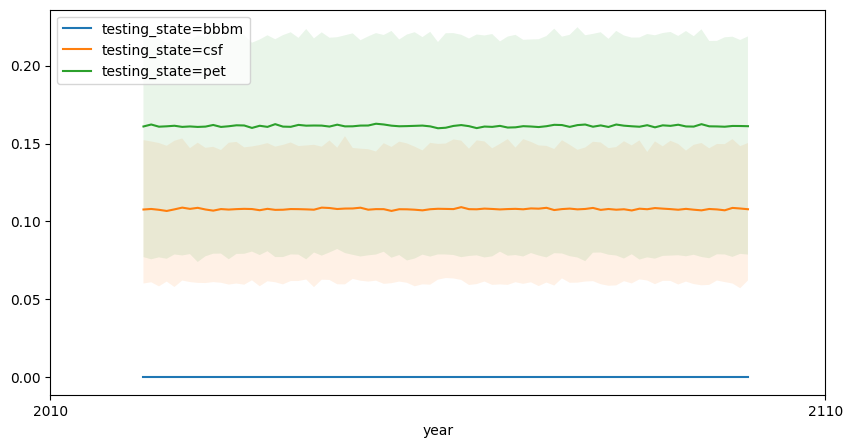

In [38]:
fig, ax = plt.subplots(figsize=(10,5))
plot_over_time_by_column(
    sim_test_rates
    .query("location == 'United States of America' and scenario == 'baseline' and testing_state != 'not_tested'"),
    'testing_state')
ax.set_xticks(ax.get_xticks()[::10])
# ax.tick_params(rotation=90)
plt.show()

# Plot existing test rates in baseline for each country

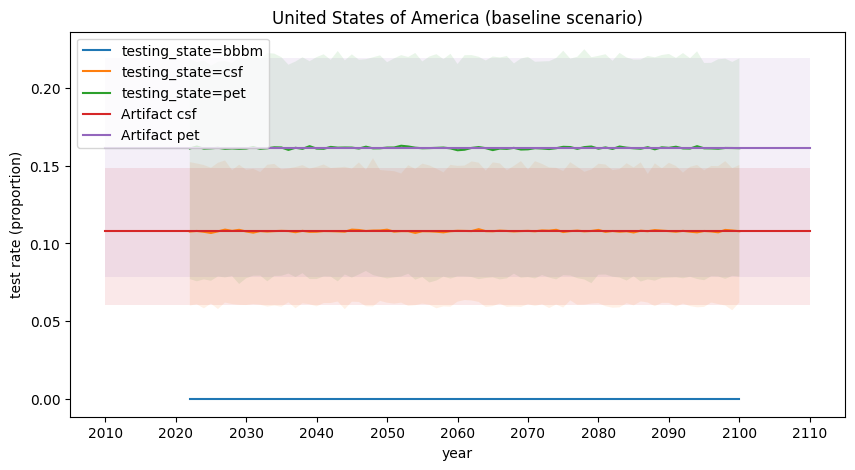

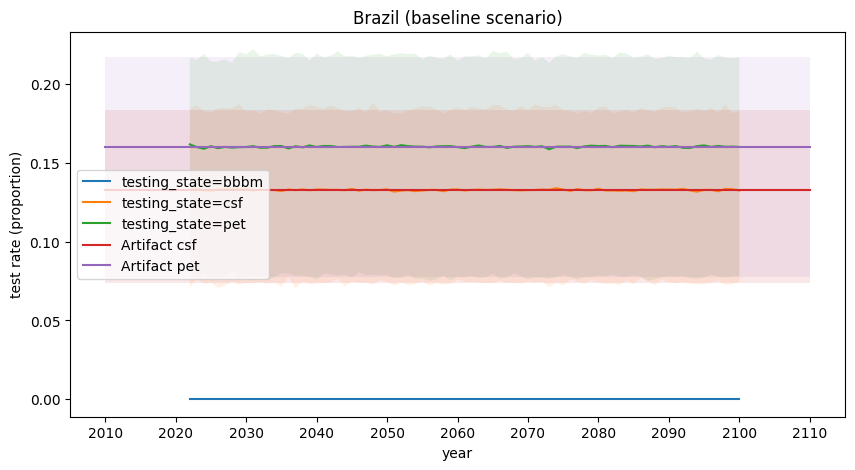

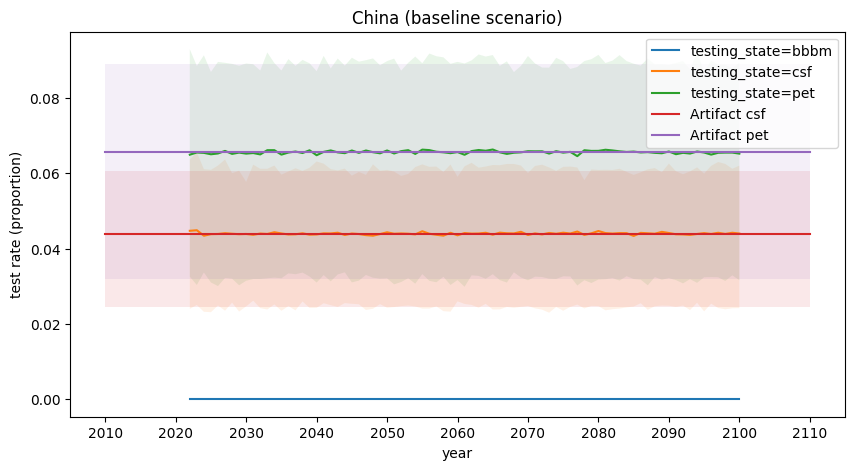

In [105]:
for location in locations:
    fig, ax = plt.subplots(figsize=(10,5))
    plot_over_time_by_column(
        sim_test_rates
        .query("location == @location and scenario == 'baseline' and testing_state != 'not_tested'"),
        'testing_state',
        ylabel='test rate (proportion)',
        title=location + ' (baseline scenario)',
    )
    filtered_x_ticks = ax.get_xticks()#[::5]
    ax.set_xticks(filtered_x_ticks)

    artifact_testing_data = summarize_artifact_data(
        # NOTE: PET testing rates look too high if we don't filter to
        # draws used in sim
        existing_test_rates[draw_cols]).query("location==@location")
    for test_type in artifact_testing_data.index.unique('test_type'):
        ax.plot(
            filtered_x_ticks,
            np.broadcast_to(artifact_testing_data.loc[test_type, 'mean'], (len(filtered_x_ticks),)),
            label=f'Artifact {test_type}'
        )
        ax.fill_between(
            filtered_x_ticks,
            np.broadcast_to(artifact_testing_data.loc[test_type, 'lower'], (len(filtered_x_ticks),)),
            np.broadcast_to(artifact_testing_data.loc[test_type, 'upper'], (len(filtered_x_ticks),)),
            alpha=.1,
        )
    # ax.tick_params(rotation=90)
    # ax.semilogy()
    # ax.set_ylim(0, 0.1)
    ax.legend()
    plt.show()

In [40]:
artifact_testing_data

,,mean,lower,upper
test_type,location,,,
csf,China,0.044002,0.022751,0.066817
pet,China,0.061033,0.029244,0.091719


# Plot existing tests in baseline and BBBM testing scenarios for one country

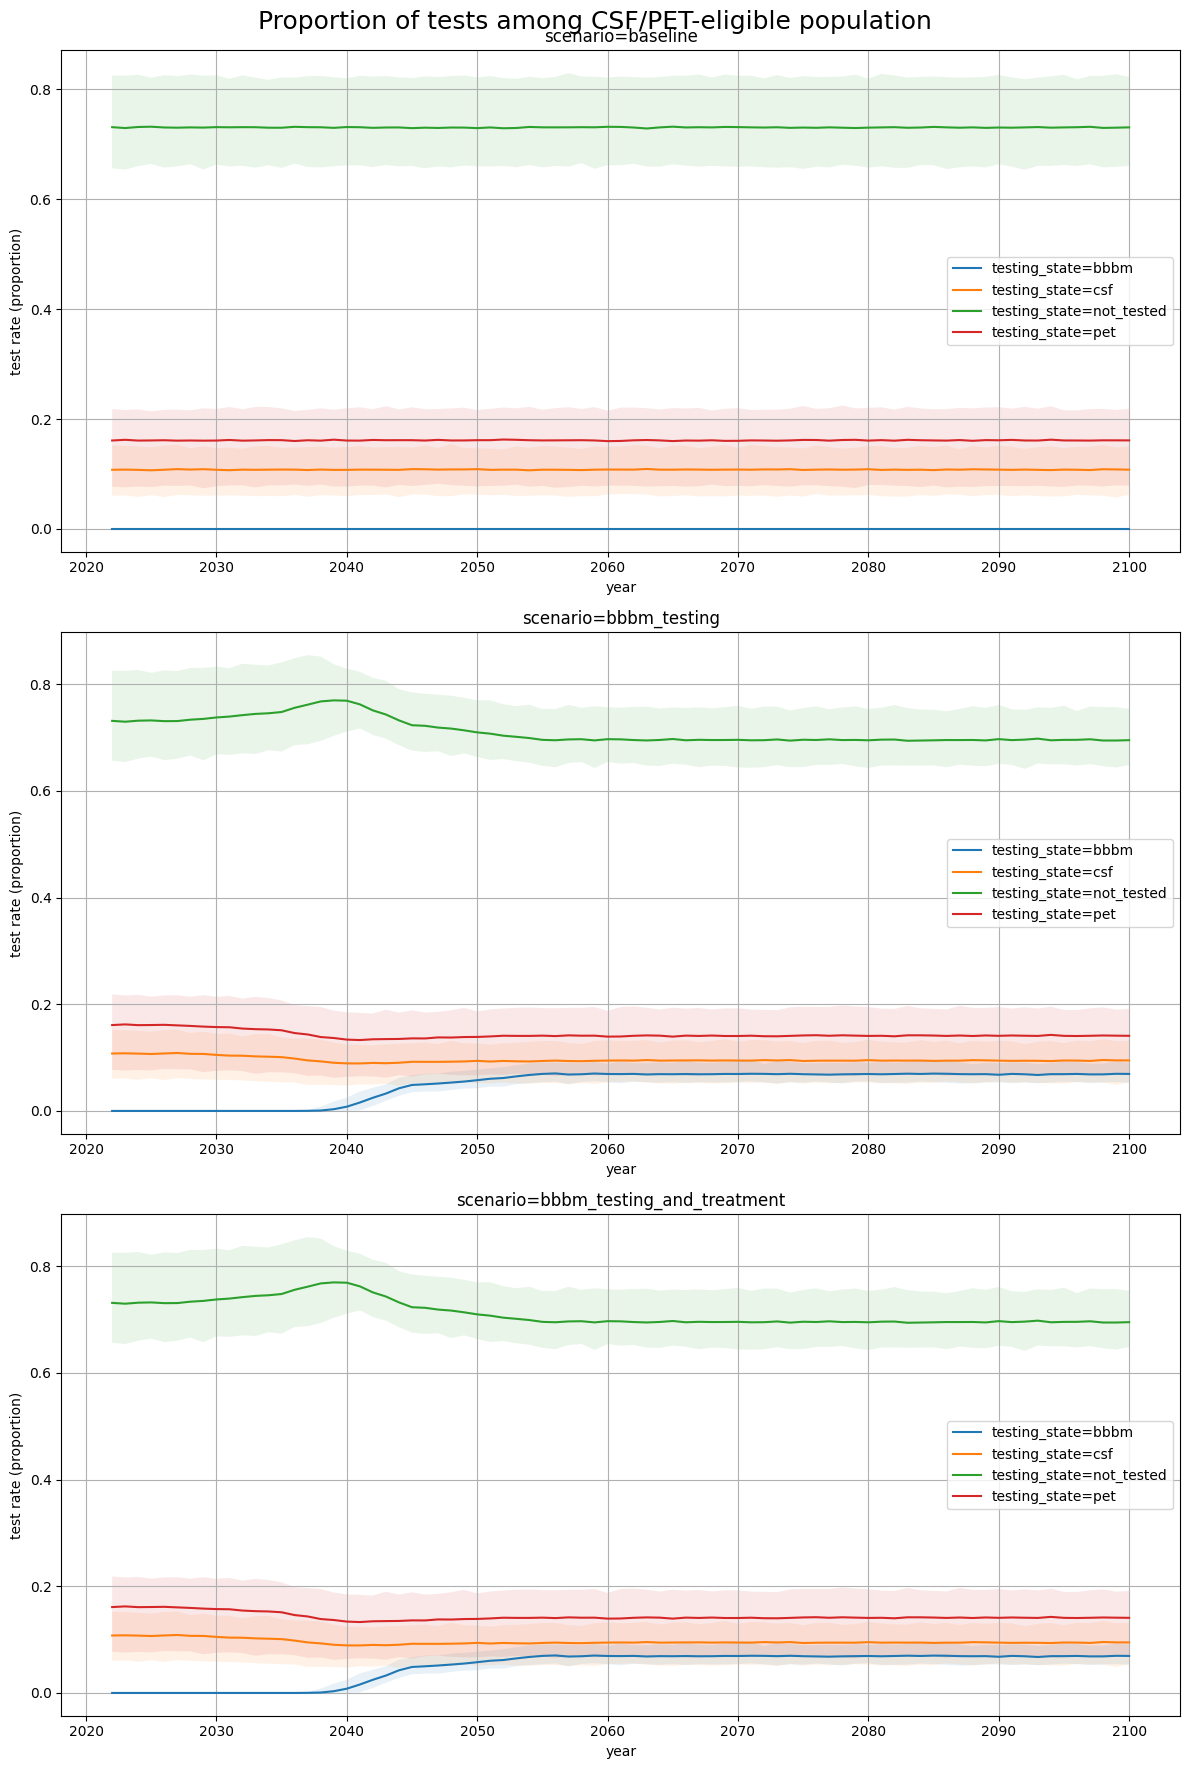

In [41]:
fig = plot_over_time_by_column_for_row_x_1(
    sim_test_rates.query("location == 'United States of America'"),
    'testing_state',
    'scenario',
    ylabel='test rate (proportion)',
    suptitle='Proportion of tests among CSF/PET-eligible population',
)
for ax in fig.axes:
    ax.grid(True)
#     ax.set_xticks(ax.get_xticks()[::5])
plt.show()

# Plot existing test rates in BBBM testing scenario for all countries

CSF now decreases at the same time as PET testing. Looks like the bugfix worked.

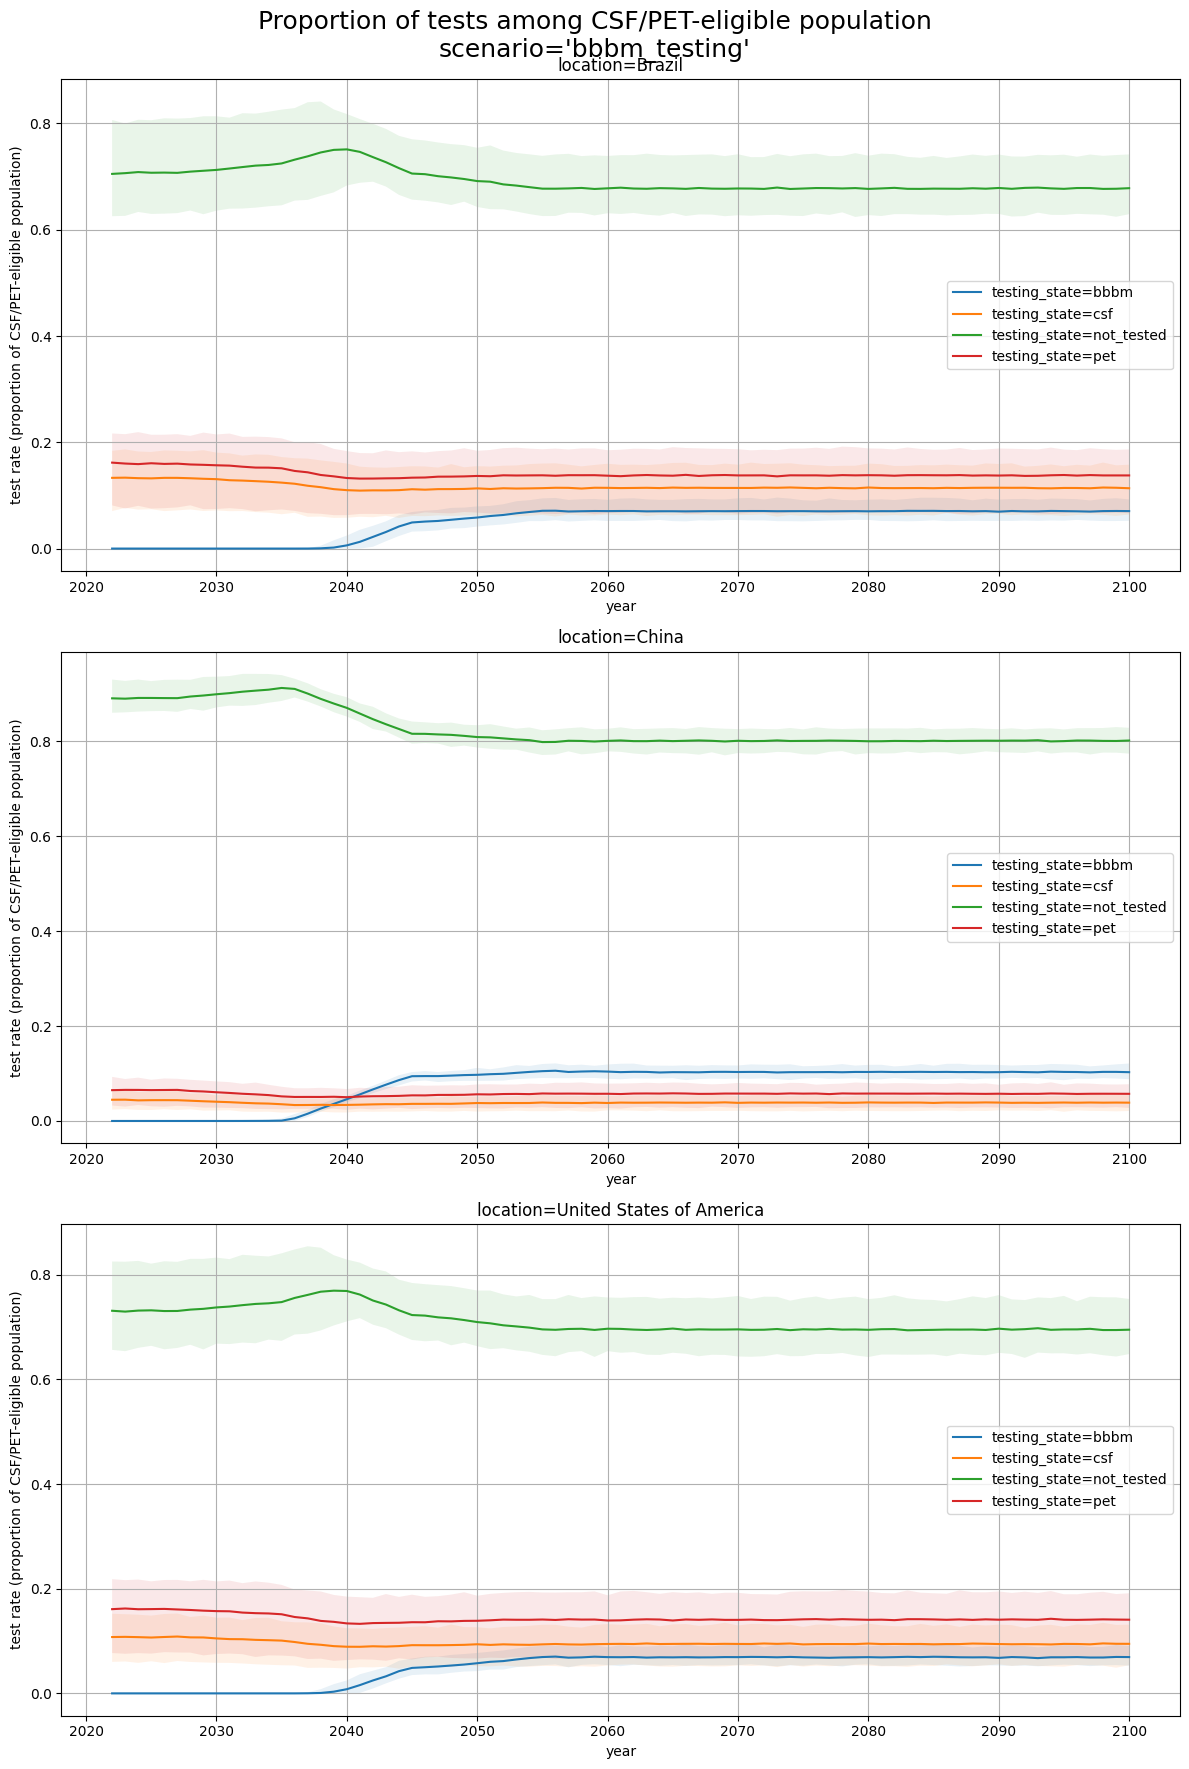

In [42]:
scenario='bbbm_testing'
fig = plot_over_time_by_column_for_row_x_1(
    sim_test_rates.query("scenario == @scenario"),
    'testing_state',
    'location',
    ylabel='test rate (proportion of CSF/PET-eligible population)',
    suptitle=(
        'Proportion of tests among CSF/PET-eligible population'
        f'\n{scenario=}'
    ),
)
for ax in fig.axes:
    ax.grid(True)
#     ax.set_xticks(ax.get_xticks()[::5])
plt.show()

# Plot existing test rates in treatment scenario for all countries

These graphs should look the same as the ones in the testing scenario.
And they do. Good.

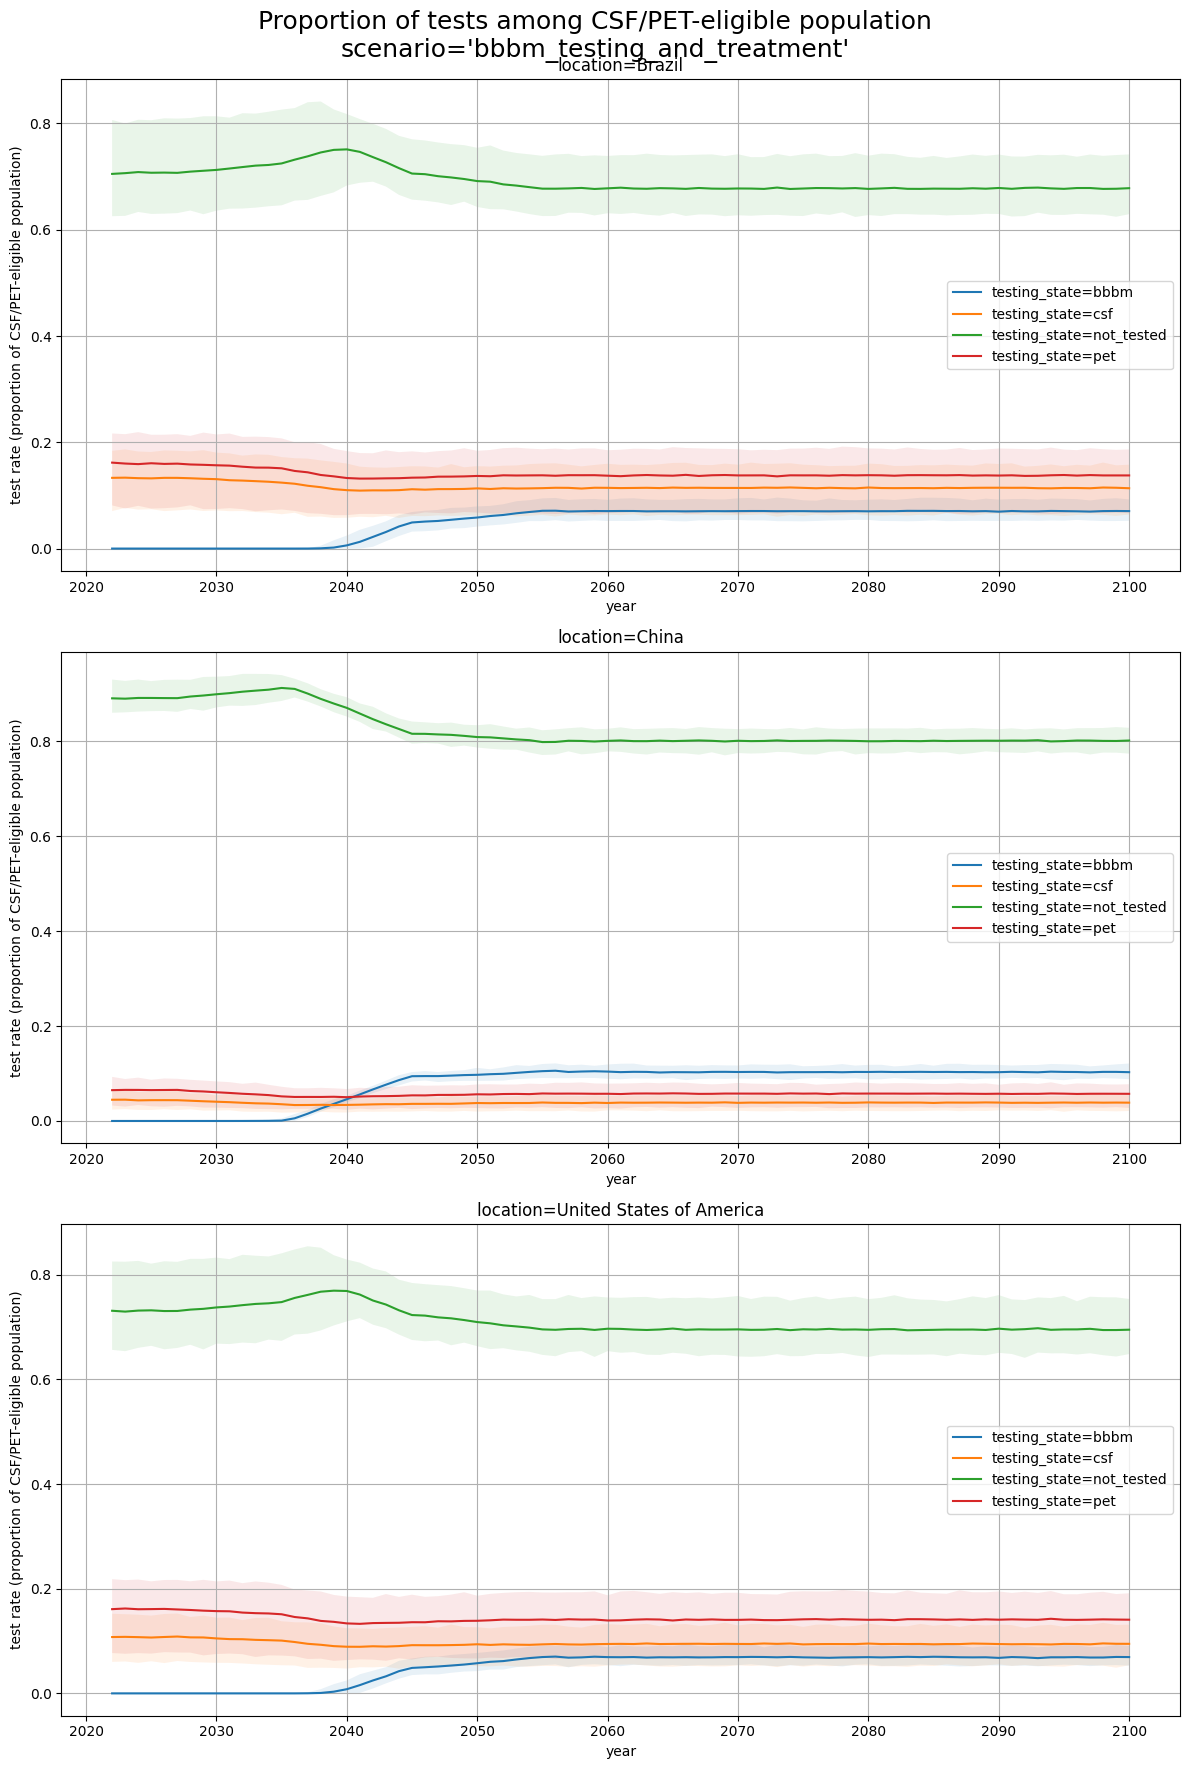

In [43]:
scenario='bbbm_testing_and_treatment'
fig = plot_over_time_by_column_for_row_x_1(
    sim_test_rates.query("scenario == @scenario"),
    'testing_state',
    'location',
    ylabel='test rate (proportion of CSF/PET-eligible population)',
    suptitle=(
        'Proportion of tests among CSF/PET-eligible population'
        f'\n{scenario=}'
    ),
)
for ax in fig.axes:
    ax.grid(True)
#     ax.set_xticks(ax.get_xticks()[::5])
plt.show()

# Read BBBM testing data

In [44]:
bbbm_test_eligibility_counts = load_sim_output(
    'counts_newly_eligible_for_bbbm_testing',
)
print_memory_usage(bbbm_test_eligibility_counts)
bbbm_test_eligibility_counts

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/brazil.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'])
44.797133 MB


,age_group,artifact_path,bbbm_test_results,entity,entity_type,event_year,input_draw,measure,scenario,sex,sub_entity,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,counts_newly_eligible_for_bbbm_testing,baseline,Female,,0.0,United States of America
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,counts_newly_eligible_for_bbbm_testing,baseline,Male,,0.0,United States of America
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,counts_newly_eligible_for_bbbm_testing,bbbm_testing,Female,,0.0,United States of America
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,counts_newly_eligible_for_bbbm_testing,bbbm_testing,Male,,0.0,United States of America
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,counts_newly_eligible_for_bbbm_testing,bbbm_testing_and_treatment,Female,,0.0,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599745,95_plus,/mnt/team/simulation_science/pub/models/vivari...,positive,bbbm_testing,testing,2100,249,counts_newly_eligible_for_bbbm_testing,baseline,Male,,0.0,Brazil
1599746,95_plus,/mnt/team/simulation_science/pub/models/vivari...,positive,bbbm_testing,testing,2100,249,counts_newly_eligible_for_bbbm_testing,bbbm_testing,Female,,0.0,Brazil
1599747,95_plus,/mnt/team/simulation_science/pub/models/vivari...,positive,bbbm_testing,testing,2100,249,counts_newly_eligible_for_bbbm_testing,bbbm_testing,Male,,0.0,Brazil
1599748,95_plus,/mnt/team/simulation_science/pub/models/vivari...,positive,bbbm_testing,testing,2100,249,counts_newly_eligible_for_bbbm_testing,bbbm_testing_and_treatment,Female,,0.0,Brazil


In [45]:
bbbm_test_eligibility_counts.bbbm_test_results.unique()

['negative', 'not_tested', 'positive']
Categories (3, object): ['negative', 'not_tested', 'positive']

In [46]:
bbbm_test_counts = load_sim_output(
    'counts_bbbm_tests',
)
bbbm_test_counts

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/brazil.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'])


,age_group,artifact_path,bbbm_test_results,entity,entity_type,event_year,input_draw,measure,scenario,sex,sub_entity,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,counts_bbbm_tests,baseline,Female,,0.0,United States of America
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,counts_bbbm_tests,baseline,Male,,0.0,United States of America
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,counts_bbbm_tests,bbbm_testing,Female,,0.0,United States of America
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,counts_bbbm_tests,bbbm_testing,Male,,0.0,United States of America
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,counts_bbbm_tests,bbbm_testing_and_treatment,Female,,0.0,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599745,95_plus,/mnt/team/simulation_science/pub/models/vivari...,positive,bbbm_testing,testing,2100,249,counts_bbbm_tests,baseline,Male,,0.0,Brazil
1599746,95_plus,/mnt/team/simulation_science/pub/models/vivari...,positive,bbbm_testing,testing,2100,249,counts_bbbm_tests,bbbm_testing,Female,,0.0,Brazil
1599747,95_plus,/mnt/team/simulation_science/pub/models/vivari...,positive,bbbm_testing,testing,2100,249,counts_bbbm_tests,bbbm_testing,Male,,0.0,Brazil
1599748,95_plus,/mnt/team/simulation_science/pub/models/vivari...,positive,bbbm_testing,testing,2100,249,counts_bbbm_tests,bbbm_testing_and_treatment,Female,,0.0,Brazil


# Check that BBBM tests are only occurring between ages 60-80

Yep. Good.

In [47]:
bbbm_test_eligibility_counts.query("value > 0").age_group.unique()

['65_to_69', '70_to_74', '75_to_79']
Categories (15, object): ['25_to_29' < '30_to_34' < '35_to_39' < '40_to_44' ... '80_to_84' < '85_to_89' < '90_to_94' < '95_plus']

In [48]:
bbbm_test_counts.query("value > 0").age_group.unique()

['65_to_69', '70_to_74', '75_to_79']
Categories (15, object): ['25_to_29' < '30_to_34' < '35_to_39' < '40_to_44' ... '80_to_84' < '85_to_89' < '90_to_94' < '95_plus']

# Divide to get BBBM testing rates for each year in each location

Aggregate over age groups and sexes to get a single number for each
location and year. Stratify by BBBM test results by broadcasting in the
numerator.

In [49]:
bbbm_test_rate = ops.ratio(
    bbbm_test_counts,
    bbbm_test_eligibility_counts,
     # Location is already in index columns, so stratify by year only
    strata=['event_year'],
    numerator_broadcast='bbbm_test_results',
)
bbbm_test_rate

,event_year,bbbm_test_results,input_draw,scenario,location,value,numerator_measure,denominator_measure,multiplier
0,2022,negative,1,baseline,Brazil,0.000000,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1
1,2022,not_tested,1,baseline,Brazil,0.000000,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1
2,2022,positive,1,baseline,Brazil,0.000000,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1
3,2022,negative,1,baseline,China,0.000000,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1
4,2022,not_tested,1,baseline,China,0.000000,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1
...,...,...,...,...,...,...,...,...,...
53320,2100,not_tested,249,bbbm_testing_and_treatment,China,0.000000,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1
53321,2100,positive,249,bbbm_testing_and_treatment,China,0.233536,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1
53322,2100,negative,249,bbbm_testing_and_treatment,United States of America,0.263692,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1
53323,2100,not_tested,249,bbbm_testing_and_treatment,United States of America,0.000000,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1


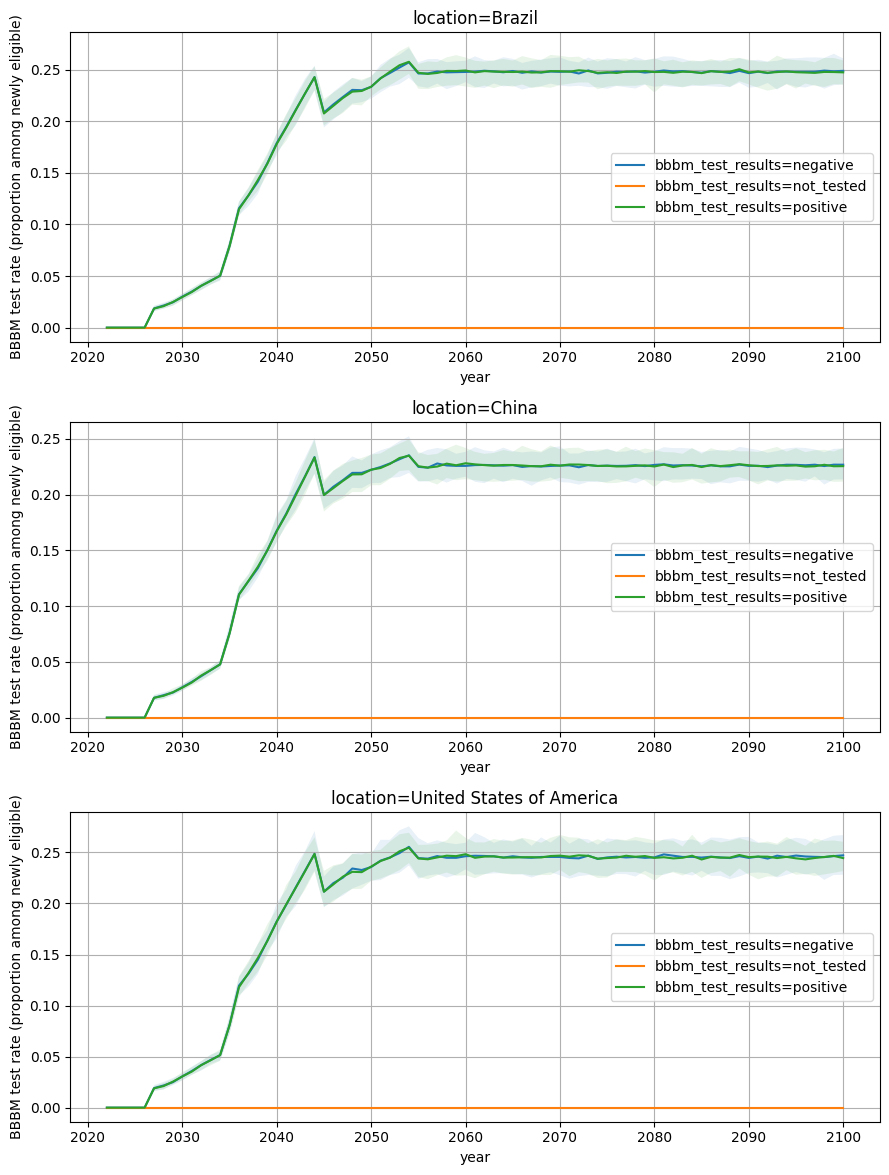

In [50]:
fig = plot_over_time_by_column_for_row_x_1(
    bbbm_test_rate.query("scenario=='bbbm_testing'"),
    'bbbm_test_results',
    'location',
    ylabel='BBBM test rate (proportion among newly eligible)',
    uncertainty=True,
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax.grid(True)
#     ax.set_xticks(ax.get_xticks()[::5])
plt.show()


# Check whether `not_tested` is ever nonzero among BBBM test counts

No, it's always zero. That's good.

In [51]:
# Good -- when counting tested simulants, the results are never "not tested"
bbbm_test_counts.query("bbbm_test_results == 'not_tested'").value.unique()

array([0.])

In [52]:
# On the other hand, among eligible simulants, there are lots of people
# who haven't been tested
bbbm_test_eligibility_counts.query("bbbm_test_results == 'not_tested'").value.unique()

array([   0., 3729., 1636., ...,  241., 5505., 5524.])

# Check that among eligible similants, there are no positive tests

Yes, all counts of positive tests among eligible simulants are zero.

In [53]:
# Good -- among eligible simulants, no one has tested positive.
bbbm_test_eligibility_counts.query("bbbm_test_results == 'positive'").value.unique()

array([0.])

In [54]:
# On the other hand, among tested simulants, there are positive test results
len(bbbm_test_counts.query("bbbm_test_results == 'positive'").value.unique())

1408

# Check test sensitivity

Filter to testing scenario and/or treatment scenario since there are no BBBM tests in baseline.

In [55]:
bbbm_test_sensitivity = ops.ratio(
    bbbm_test_counts,
    bbbm_test_counts,
    strata=['event_year'],
    # prefilter_query="scenario=='bbbm_testing'",
    # Broadcast in numerator to get positive and negative test results
    numerator_broadcast='bbbm_test_results',
    # dropna=True, # Drop rows with 0 testing (baseline scenario and years < 2030)
)
bbbm_test_sensitivity

,event_year,bbbm_test_results,input_draw,scenario,location,value,numerator_measure,denominator_measure,multiplier
0,2022,negative,1,baseline,Brazil,NaN,counts_bbbm_tests,counts_bbbm_tests,1
1,2022,not_tested,1,baseline,Brazil,NaN,counts_bbbm_tests,counts_bbbm_tests,1
2,2022,positive,1,baseline,Brazil,NaN,counts_bbbm_tests,counts_bbbm_tests,1
3,2022,negative,1,baseline,China,NaN,counts_bbbm_tests,counts_bbbm_tests,1
4,2022,not_tested,1,baseline,China,NaN,counts_bbbm_tests,counts_bbbm_tests,1
...,...,...,...,...,...,...,...,...,...
53320,2100,not_tested,249,bbbm_testing_and_treatment,China,0.000000,counts_bbbm_tests,counts_bbbm_tests,1
53321,2100,positive,249,bbbm_testing_and_treatment,China,0.499135,counts_bbbm_tests,counts_bbbm_tests,1
53322,2100,negative,249,bbbm_testing_and_treatment,United States of America,0.514479,counts_bbbm_tests,counts_bbbm_tests,1
53323,2100,not_tested,249,bbbm_testing_and_treatment,United States of America,0.000000,counts_bbbm_tests,counts_bbbm_tests,1


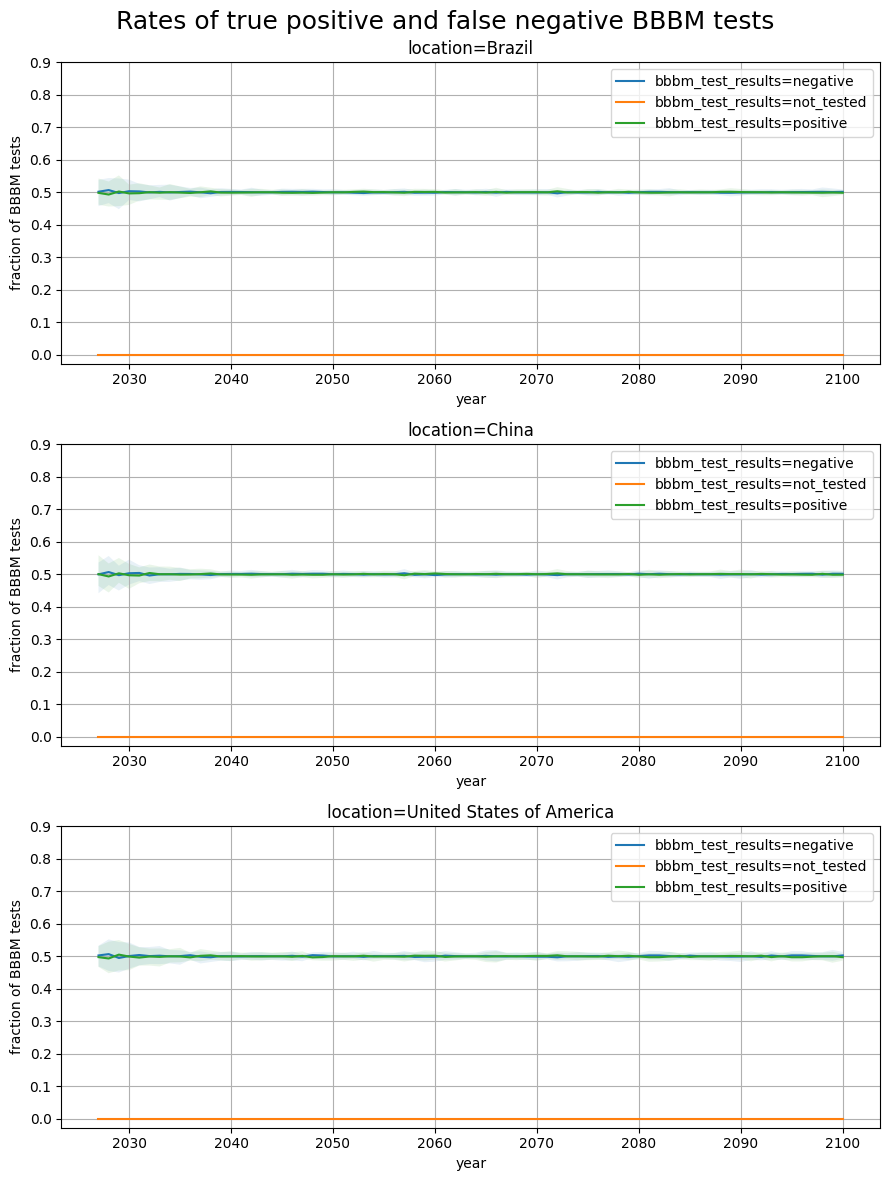

In [56]:
scenario = 'bbbm_testing_and_treatment'
fig = plot_over_time_by_column_for_row_x_1(
    bbbm_test_sensitivity.query("scenario == 'bbbm_testing_and_treatment'"),
    'bbbm_test_results',
    'location',
    ylabel='fraction of BBBM tests',
    suptitle='Rates of true positive and false negative BBBM tests',
    uncertainty=True,
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::5])
    ax.set_yticks(np.arange(0,1, .1))
    ax.grid(True)
plt.show()


# Compute statistics on BBBM test sensitivity

In [57]:
bbbm_test_sensitivity_summary = ops.describe(
    bbbm_test_sensitivity.dropna().query("event_year >= 2030 and bbbm_test_results=='positive'"))
bbbm_test_sensitivity_summary

count  \
bbbm_test_results denominator_measure event_year location                 multiplier numerator_measure scenario                            
positive          counts_bbbm_tests   2030       Brazil                   1          counts_bbbm_tests bbbm_testing                 25.0   
                                                                                                       bbbm_testing_and_treatment   25.0   
                                                 China                    1          counts_bbbm_tests bbbm_testing                 25.0   
                                                                                                       bbbm_testing_and_treatment   25.0   
                                                 United States of America 1          counts_bbbm_tests bbbm_testing                 25.0   
...                                                                                                                                  ...   
                                      2100       Brazil                   1          counts_bbbm_tests bbbm_testing_and_treatment   25.0   
                                                 China                    1          counts_bbbm_tests bbbm_testing                 25.0   
                                                                                                       bbbm_testing_and_treatment   25.0   
                                                 United States of America 1          counts_bbbm_tests bbbm_testing                 25.0   
                                                                                                       bbbm_testing_and_treatment   25.0   

                                                                                                                                       mean  \
bbbm_test_results denominator_measure event_year location                 multiplier numerator_measure scenario                               
positive          counts_bbbm_tests   2030       Brazil                   1          counts_bbbm_tests bbbm_testing                0.496568   
                                                                                                       bbbm_testing_and_treatment  0.496568   
                                                 China                    1          counts_bbbm_tests bbbm_testing                0.496854   
                                                                                                       bbbm_testing_and_treatment  0.496854   
                                                 United States of America 1          counts_bbbm_tests bbbm_testing                0.499202   
...                                                                                                                                     ...   
                                      2100       Brazil                   1          counts_bbbm_tests bbbm_testing_and_treatment  0.498543   
                                                 China                    1          counts_bbbm_tests bbbm_testing                0.498563   
                                                                                                       bbbm_testing_and_treatment  0.498563   
                                                 United States of America 1          counts_bbbm_tests bbbm_testing                0.497328   
                                                                                                       bbbm_testing_and_treatment  0.497328   

                                                                                                                                        std  \
bbbm_test_results denominator_measure event_year location                 multiplier numerator_measure scenario                               
positive          counts_bbbm_tests   2030       Brazil                   1          counts_bbbm_tests bbbm_testing                0.020030   
                     

In [58]:
bbbm_test_sensitivity_summary['mean'].describe()

count    426.000000
mean       0.499794
std        0.001330
min        0.495980
25%        0.499079
50%        0.499795
75%        0.500531
max        0.503877
Name: mean, dtype: float64

# Compute test result fractions among newly eligible simulants

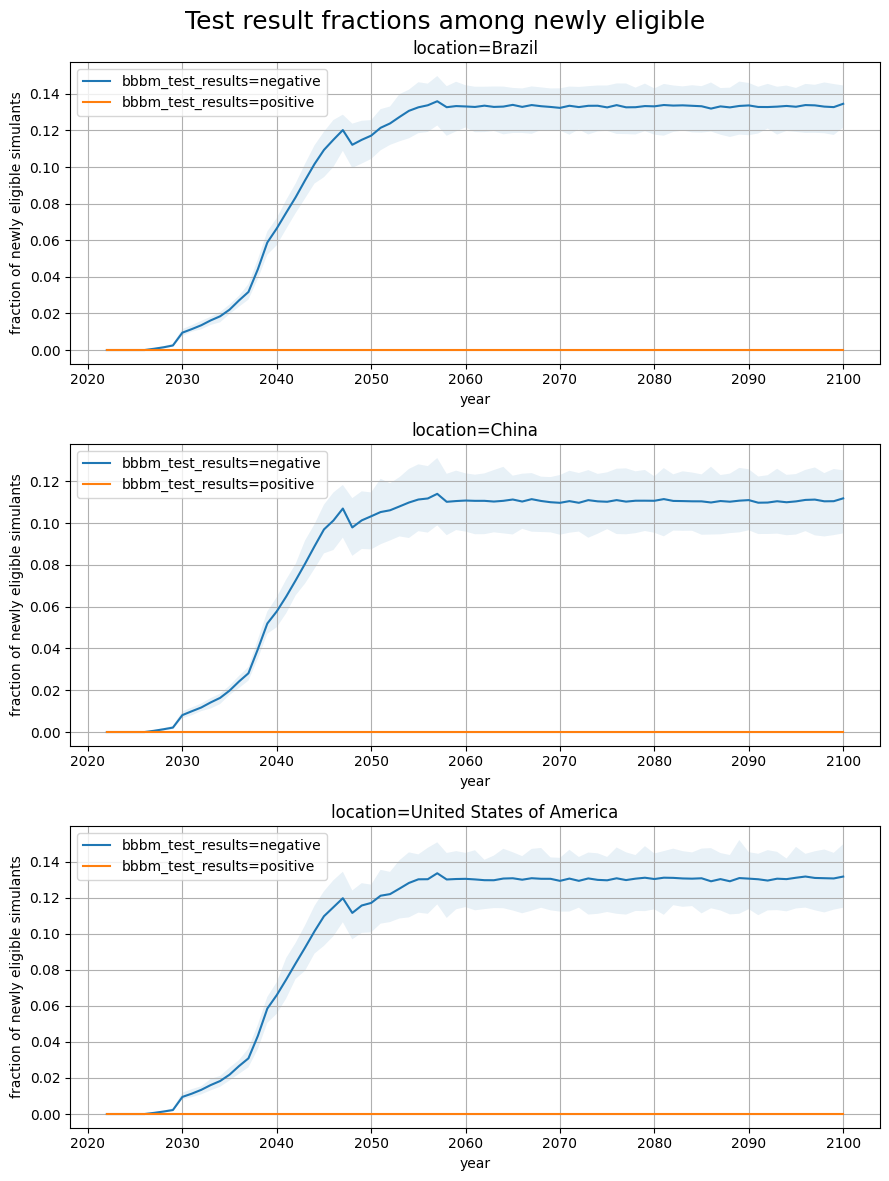

In [59]:
# TODO: Here would be a great place to use prefilter_query in the ratio
# function, once I implement it
bbbm_test_result_fractions_among_eligible = ops.ratio(
    bbbm_test_eligibility_counts,#.query("scenario=='bbbm_testing'"),
    bbbm_test_eligibility_counts,#.query("scenario=='bbbm_testing'"),
    strata=['event_year'],
    numerator_broadcast='bbbm_test_results',
    prefilter_query="scenario=='bbbm_testing'",
)

fig = plot_over_time_by_column_for_row_x_1(
    bbbm_test_result_fractions_among_eligible.query("bbbm_test_results != 'not_tested'"),
    'bbbm_test_results',
    'location',
    ylabel='fraction of newly eligible simulants',
    suptitle='Test result fractions among newly eligible',
    uncertainty=True,
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.set_xticks(ax.get_xticks()[::5])
    # ax.set_yticks(np.arange(0,1, .1))
    # ax.semilogy()
plt.show()

# Plot numerators and denominators of BBBM test rate

In [60]:
bbbm_test_rate_numerator = ops.stratify(bbbm_test_counts, 'event_year')
bbbm_test_rate_denominator = ops.stratify(bbbm_test_eligibility_counts, 'event_year')
bbbm_test_rate_num_and_denom = pd.concat(
    [bbbm_test_rate_numerator, bbbm_test_rate_denominator],
    keys=['tests', 'newly_eligible'],
    names=['count'],
).reset_index('count').reset_index(drop=True)
bbbm_test_rate_num_and_denom

,count,event_year,input_draw,scenario,location,value
0,tests,2022,1,baseline,Brazil,0.0
1,tests,2022,1,baseline,China,0.0
2,tests,2022,1,baseline,United States of America,0.0
3,tests,2022,1,bbbm_testing,Brazil,0.0
4,tests,2022,1,bbbm_testing,China,0.0
...,...,...,...,...,...,...
35545,newly_eligible,2100,249,bbbm_testing,China,18541.0
35546,newly_eligible,2100,249,bbbm_testing,United States of America,10645.0
35547,newly_eligible,2100,249,bbbm_testing_and_treatment,Brazil,20213.0
35548,newly_eligible,2100,249,bbbm_testing_and_treatment,China,18541.0


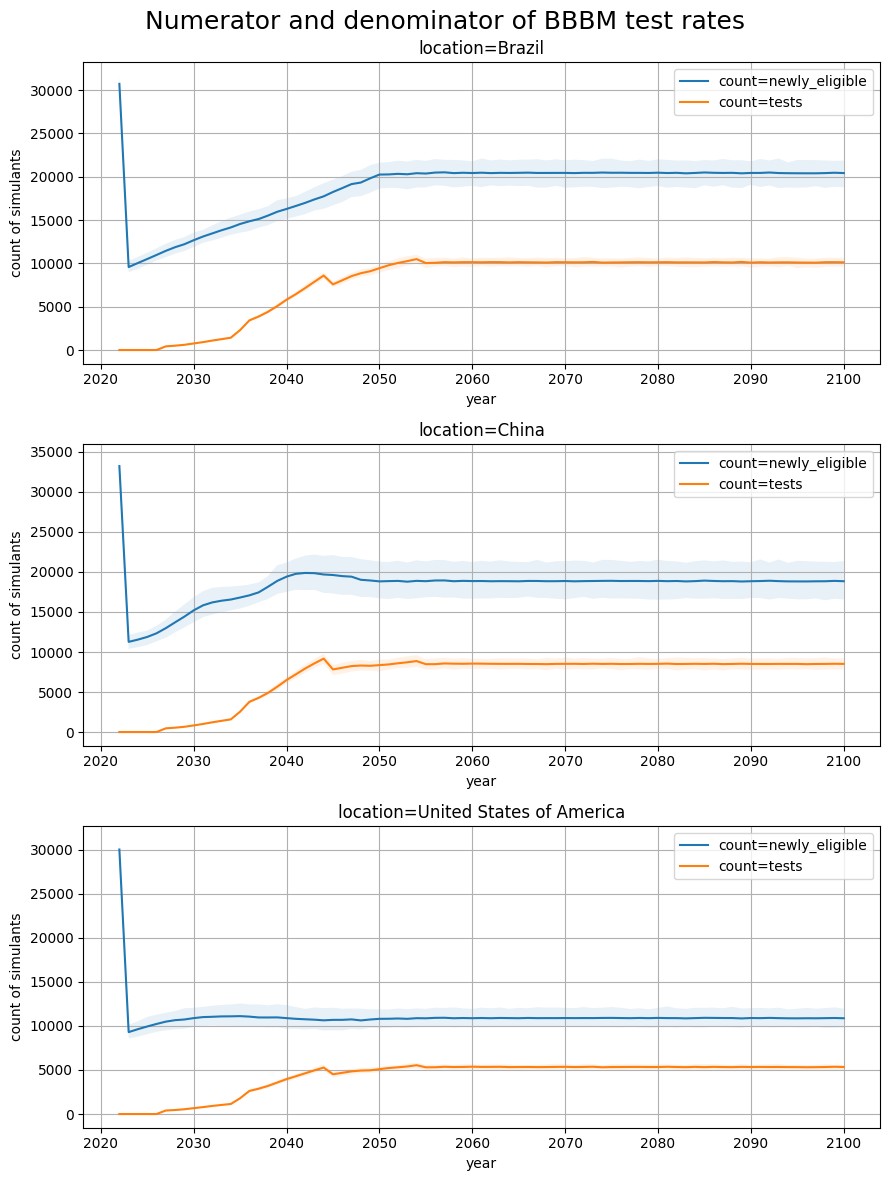

In [61]:
fig = plot_over_time_by_column_for_row_x_1(
    bbbm_test_rate_num_and_denom.query("scenario=='bbbm_testing'"),
    'count',
    'location',
    ylabel='count of simulants',
    suptitle='Numerator and denominator of BBBM test rates',
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.set_xticks(ax.get_xticks()[::5])
plt.show()

# Read in BBBM testing person-time data

In [62]:
pt_ever_eligible_bbbm = load_sim_output(
    'person_time_ever_eligible_for_bbbm_testing'
)
print_memory_usage(pt_ever_eligible_bbbm)
pt_ever_eligible_bbbm

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/brazil.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'])
139.18277 MB


,age_group,alzheimers_disease_and_other_dementias,artifact_path,bbbm_test_results,entity,entity_type,event_year,input_draw,measure,scenario,sex,sub_entity,value,location
0,25_to_29,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,person_time_ever_eligible_for_bbbm_testing,baseline,Female,,0.000000,United States of America
1,25_to_29,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,person_time_ever_eligible_for_bbbm_testing,baseline,Male,,0.000000,United States of America
2,25_to_29,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,,0.000000,United States of America
3,25_to_29,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Male,,0.000000,United States of America
4,25_to_29,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,person_time_ever_eligible_for_bbbm_testing,bbbm_testing_and_treatment,Female,,0.000000,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4799245,95_plus,alzheimers_mild_cognitive_impairment_state,/mnt/team/simulation_science/pub/models/vivari...,positive,bbbm_testing,testing,2100,249,person_time_ever_eligible_for_bbbm_testing,baseline,Male,,0.000000,Brazil
4799246,95_plus,alzheimers_mild_cognitive_impairment_state,/mnt/team/simulation_science/pub/models/vivari...,positive,bbbm_testing,testing,2100,249,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,,152.974675,Brazil
4799247,95_plus,alzheimers_mild_cognitive_impairment_state,/mnt/team/simulation_science/pub/models/vivari...,positive,bbbm_testing,testing,2100,249,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Male,,50.825462,Brazil
4799248,95_plus,alzheimers_mild_cognitive_impairment_state,/mnt/team/simulation_science/pub/models/vivari...,positive,bbbm_testing,testing,2100,249,person_time_ever_eligible_for_bbbm_testing,bbbm_testing_and_treatment,Female,,305.949350,Brazil


In [63]:
pt_eligible_bbbm = load_sim_output(
    'person_time_eligible_for_bbbm_testing'
)
print_memory_usage(pt_eligible_bbbm)
pt_eligible_bbbm

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/brazil.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf'])
44.797132 MB


,age_group,artifact_path,bbbm_test_results,entity,entity_type,event_year,input_draw,measure,scenario,sex,sub_entity,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,person_time_eligible_for_bbbm_testing,baseline,Female,,0.0,United States of America
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,person_time_eligible_for_bbbm_testing,baseline,Male,,0.0,United States of America
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,person_time_eligible_for_bbbm_testing,bbbm_testing,Female,,0.0,United States of America
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,person_time_eligible_for_bbbm_testing,bbbm_testing,Male,,0.0,United States of America
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,person_time_eligible_for_bbbm_testing,bbbm_testing_and_treatment,Female,,0.0,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599745,95_plus,/mnt/team/simulation_science/pub/models/vivari...,positive,bbbm_testing,testing,2100,249,person_time_eligible_for_bbbm_testing,baseline,Male,,0.0,Brazil
1599746,95_plus,/mnt/team/simulation_science/pub/models/vivari...,positive,bbbm_testing,testing,2100,249,person_time_eligible_for_bbbm_testing,bbbm_testing,Female,,0.0,Brazil
1599747,95_plus,/mnt/team/simulation_science/pub/models/vivari...,positive,bbbm_testing,testing,2100,249,person_time_eligible_for_bbbm_testing,bbbm_testing,Male,,0.0,Brazil
1599748,95_plus,/mnt/team/simulation_science/pub/models/vivari...,positive,bbbm_testing,testing,2100,249,person_time_eligible_for_bbbm_testing,bbbm_testing_and_treatment,Female,,0.0,Brazil


# Plot BBBM testing rate (counts / eligible person-time)

In [64]:
bbbm_tests_per_eligible_pt = ops.ratio(
    bbbm_test_counts,
    pt_eligible_bbbm,
    strata='event_year',
    # numerator_broadcast='bbbm_test_results',
)
bbbm_tests_per_eligible_pt

,event_year,input_draw,scenario,location,value,numerator_measure,denominator_measure,multiplier
0,2022,1,baseline,Brazil,0.000000,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1
1,2022,1,baseline,China,0.000000,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1
2,2022,1,baseline,United States of America,0.000000,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1
3,2022,1,bbbm_testing,Brazil,0.000000,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1
4,2022,1,bbbm_testing,China,0.000000,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1
...,...,...,...,...,...,...,...,...
17770,2100,249,bbbm_testing,China,0.198644,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1
17771,2100,249,bbbm_testing,United States of America,0.200639,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1
17772,2100,249,bbbm_testing_and_treatment,Brazil,0.201647,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1
17773,2100,249,bbbm_testing_and_treatment,China,0.198644,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1


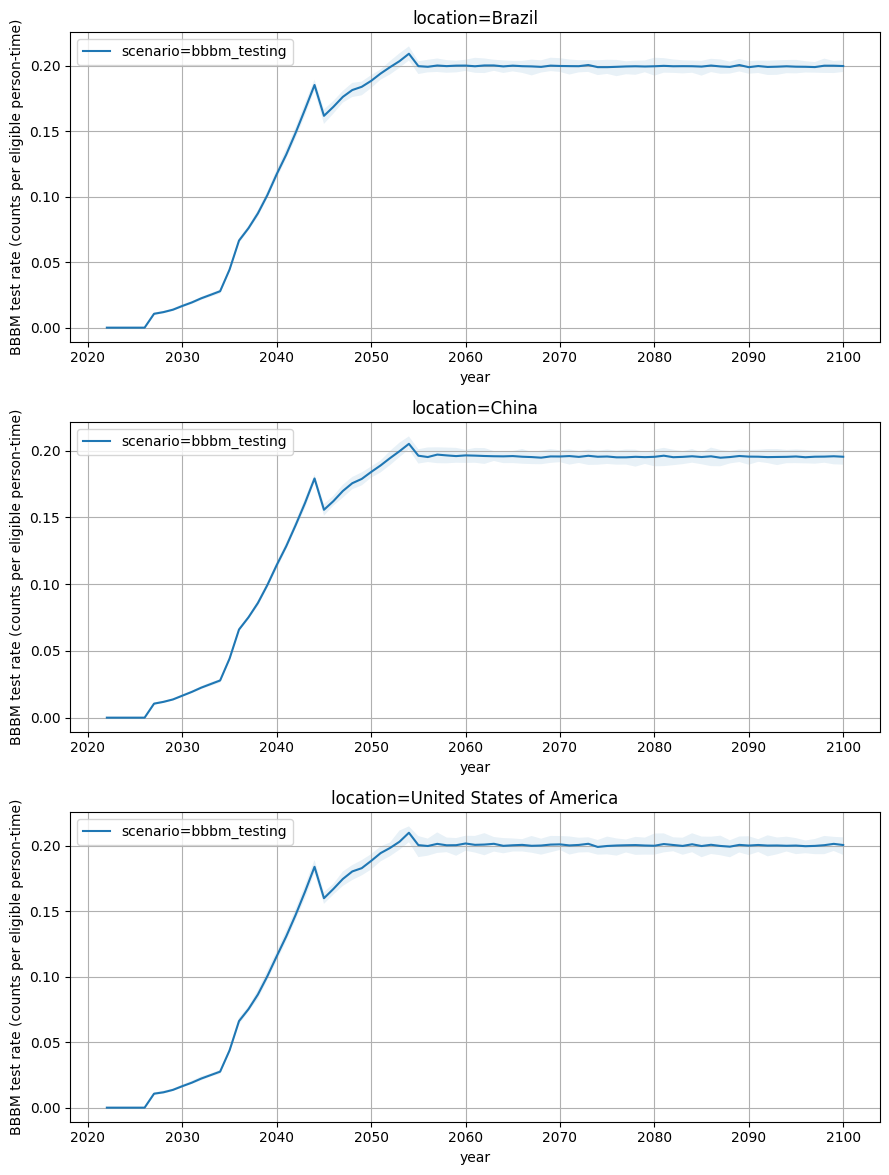

In [65]:
fig = plot_over_time_by_column_for_row_x_1(
    bbbm_tests_per_eligible_pt.query("scenario=='bbbm_testing'"),
    # 'bbbm_test_results',
    'scenario',
    'location',
    ylabel='BBBM test rate (counts per eligible person-time)',
    uncertainty=True,
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::5])
    ax.grid(True)
plt.show()


# Compute prevalence of ever tested among ever eligible

In [66]:
pt_ever_eligible_bbbm.bbbm_test_results.unique()

['negative', 'not_tested', 'positive']
Categories (3, object): ['negative', 'not_tested', 'positive']

In [67]:
pt_ever_eligible_bbbm

,age_group,alzheimers_disease_and_other_dementias,artifact_path,bbbm_test_results,entity,entity_type,event_year,input_draw,measure,scenario,sex,sub_entity,value,location
0,25_to_29,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,person_time_ever_eligible_for_bbbm_testing,baseline,Female,,0.000000,United States of America
1,25_to_29,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,person_time_ever_eligible_for_bbbm_testing,baseline,Male,,0.000000,United States of America
2,25_to_29,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,,0.000000,United States of America
3,25_to_29,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Male,,0.000000,United States of America
4,25_to_29,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,person_time_ever_eligible_for_bbbm_testing,bbbm_testing_and_treatment,Female,,0.000000,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4799245,95_plus,alzheimers_mild_cognitive_impairment_state,/mnt/team/simulation_science/pub/models/vivari...,positive,bbbm_testing,testing,2100,249,person_time_ever_eligible_for_bbbm_testing,baseline,Male,,0.000000,Brazil
4799246,95_plus,alzheimers_mild_cognitive_impairment_state,/mnt/team/simulation_science/pub/models/vivari...,positive,bbbm_testing,testing,2100,249,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,,152.974675,Brazil
4799247,95_plus,alzheimers_mild_cognitive_impairment_state,/mnt/team/simulation_science/pub/models/vivari...,positive,bbbm_testing,testing,2100,249,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Male,,50.825462,Brazil
4799248,95_plus,alzheimers_mild_cognitive_impairment_state,/mnt/team/simulation_science/pub/models/vivari...,positive,bbbm_testing,testing,2100,249,person_time_ever_eligible_for_bbbm_testing,bbbm_testing_and_treatment,Female,,305.949350,Brazil


In [68]:
ever_tested_over_ever_eligible = ops.ratio(
    pt_ever_eligible_bbbm.query(
        "bbbm_test_results != 'not_tested'"),
    pt_ever_eligible_bbbm,
    strata=['event_year', 'age_group'],
    prefilter_query="alzheimers_disease_and_other_dementias == 'alzheimers_blood_based_biomarker_state'",
)#.query("scenario == 'bbbm_testing_and_treatment'")
ever_tested_over_ever_eligible

,event_year,age_group,input_draw,scenario,location,value,numerator_measure,denominator_measure,multiplier
0,2022,25_to_29,1,baseline,Brazil,NaN,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
1,2022,25_to_29,1,baseline,China,NaN,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
2,2022,25_to_29,1,baseline,United States of America,NaN,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
3,2022,25_to_29,1,bbbm_testing,Brazil,NaN,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
4,2022,25_to_29,1,bbbm_testing,China,NaN,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
...,...,...,...,...,...,...,...,...,...
266620,2100,95_plus,249,bbbm_testing,China,0.541555,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
266621,2100,95_plus,249,bbbm_testing,United States of America,0.627907,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
266622,2100,95_plus,249,bbbm_testing_and_treatment,Brazil,0.703971,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
266623,2100,95_plus,249,bbbm_testing_and_treatment,China,0.679775,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1


In [69]:
ever_tested_over_ever_eligible['age_group']

0         25_to_29
1         25_to_29
2         25_to_29
3         25_to_29
4         25_to_29
            ...   
266620     95_plus
266621     95_plus
266622     95_plus
266623     95_plus
266624     95_plus
Name: age_group, Length: 266625, dtype: category
Categories (15, object): ['25_to_29' < '30_to_34' < '35_to_39' < '40_to_44' ... '80_to_84' < '85_to_89' < '90_to_94' < '95_plus']

United States of America


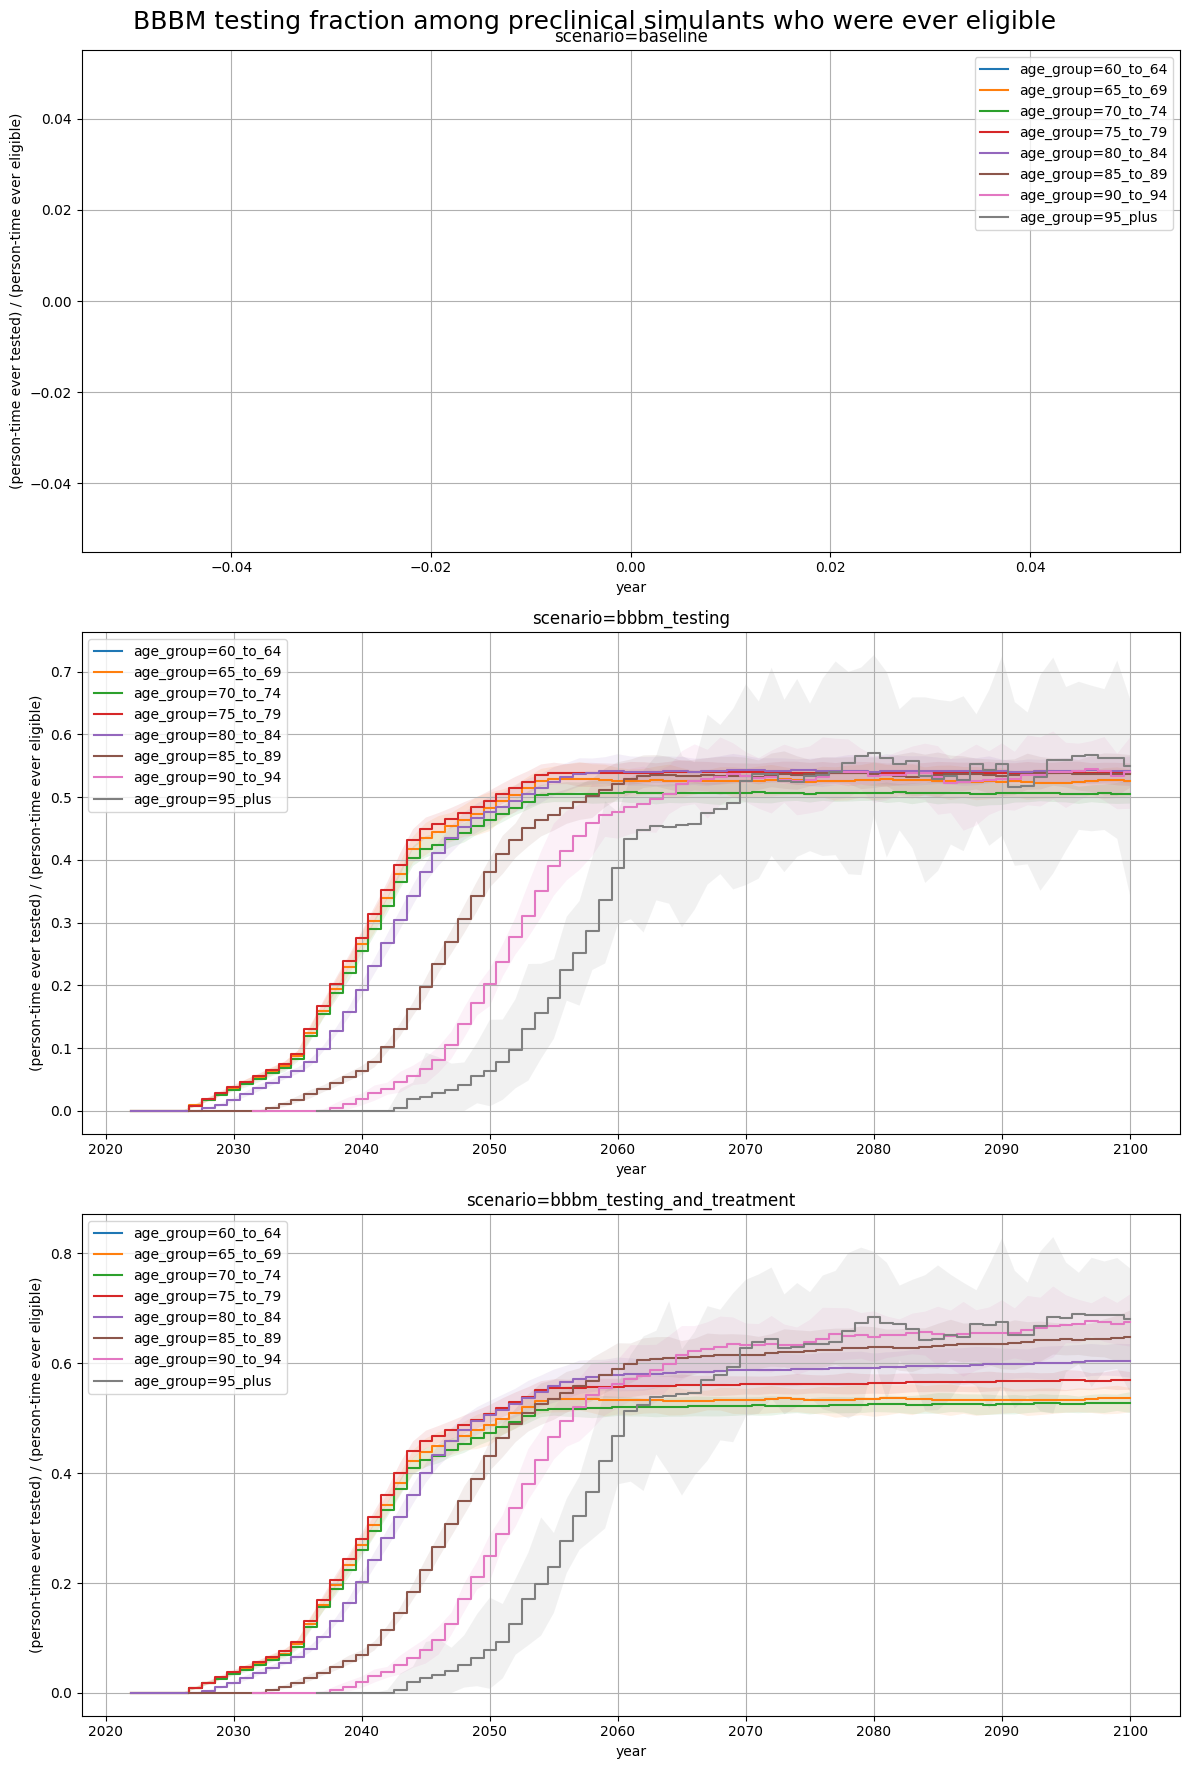

In [70]:
location = locations[0]
print(location)
# NOTE: I got "ValueError: unknown type object" when calling 
# .query("age_group < '60_to_64'") -- I fixed this by converting the
# dtype from Categorical to string. Using .loc doesn't work either
# because you can't compare unordered Categoricals. If we used an
# ordered Categorical for the age groups, that might make this easier.
# fig, ax = plt.subplots(figsize=(12, 6))
fig = plot_over_time_by_column_for_row_x_1(
    ever_tested_over_ever_eligible.astype({'age_group': str})
        .query("age_group >= '60_to_64' and location==@location"),
        #.loc[ever_tested_over_ever_eligible.age_group < '60_to_64'],
        # .query("age_group in ['60_to_64', '65_to_69', '70_to_74', '75_to_79']"),
    'age_group',
    'scenario',
    # ax=ax,
    ylabel='(person-time ever tested) / (person-time ever eligible)',
    suptitle='BBBM testing fraction among preclinical simulants who were ever eligible',
    # plot_func='step',
    # where='post',
    ds='steps-mid',
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::5])
    ax.grid(True)
plt.show()


## Try to investigate why the ratio is 1.0 for some age groups...

In [71]:
temp = ever_tested_over_ever_eligible.query("value==1.0 and scenario=='bbbm_testing'")
print(temp.age_group.unique())
temp

[], Categories (15, object): ['25_to_29' < '30_to_34' < '35_to_39' < '40_to_44' ... '80_to_84' < '85_to_89' < '90_to_94' < '95_plus']


,event_year,age_group,input_draw,scenario,location,value,numerator_measure,denominator_measure,multiplier


In [72]:
temp = pt_ever_eligible_bbbm.query(
    "scenario=='bbbm_testing' and age_group=='80_to_84'"
    " and alzheimers_disease_and_other_dementias == 'alzheimers_blood_based_biomarker_state'"
)
temp

,age_group,alzheimers_disease_and_other_dementias,artifact_path,bbbm_test_results,entity,entity_type,event_year,input_draw,measure,scenario,sex,sub_entity,value,location
3519452,80_to_84,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,,0.000000,United States of America
3519453,80_to_84,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,1,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Male,,0.000000,United States of America
3519458,80_to_84,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,6,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,,0.000000,United States of America
3519459,80_to_84,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,6,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Male,,0.000000,United States of America
3519464,80_to_84,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2022,7,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,,0.000000,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626085,80_to_84,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,positive,bbbm_testing,testing,2100,245,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Male,,1625.916496,Brazil
3626090,80_to_84,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,positive,bbbm_testing,testing,2100,248,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,,2863.665982,Brazil
3626091,80_to_84,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,positive,bbbm_testing,testing,2100,248,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Male,,1000.563997,Brazil
3626096,80_to_84,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,positive,bbbm_testing,testing,2100,249,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,,3488.021903,Brazil


In [73]:
temp.query("bbbm_test_results=='not_tested'")

,age_group,alzheimers_disease_and_other_dementias,artifact_path,bbbm_test_results,entity,entity_type,event_year,input_draw,measure,scenario,sex,sub_entity,value,location
3531302,80_to_84,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2022,1,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,,285.519507,United States of America
3531303,80_to_84,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2022,1,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Male,,119.091034,United States of America
3531308,80_to_84,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2022,6,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,,307.444216,United States of America
3531309,80_to_84,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2022,6,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Male,,197.820671,United States of America
3531314,80_to_84,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2022,7,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,,295.485284,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3614235,80_to_84,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2100,245,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Male,,2054.444901,Brazil
3614240,80_to_84,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2100,248,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,,3797.459274,Brazil
3614241,80_to_84,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2100,248,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Male,,1129.620808,Brazil
3614246,80_to_84,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2100,249,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,,4497.555099,Brazil
